This is a solution for 'TMDB Box Office Prediction' <a href="https://www.kaggle.com/c/tmdb-box-office-prediction">competition</a>  from Kaggle, where was asked to complete the task of film revenue prediction.

"*In this competition, you're presented with metadata on over 7,000 past films from The Movie Database to try and predict their overall worldwide box office revenue. Data points provided include cast, crew, plot keywords, budget, posters, release dates, languages, production companies, and countries. You can collect other publicly available data to use in your model predictions, but in the spirit of this competition, use only data that would have been available before a movie's release."

In [1]:
import numpy as np
import pandas as pd
import os
from pprint import pprint
import seaborn as sns
import re
import json
sns.set_style("darkgrid")
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.base import clone

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Ridge
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import LassoLarsIC
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from imdb import IMDb # query to TMDB for additional information
import time
import cpi # adjust revenue for inflation using the Consumer Price Index

def plot_correlation(X, y):
    '''Correlation between features X and target y'''
    correlation_analyse = pd.concat([X, y], axis=1)
    columns_ = list(X.columns)
    columns_.append('target')
    correlation_analyse.columns = columns_
    corrmatrix = correlation_analyse.corr().drop([correlation_analyse.columns[-1]])
    corrs = corrmatrix[correlation_analyse.columns[-1]].sort_values(ascending=False)

    # plot correlations
    f, ax = plt.subplots(ncols=2, figsize=(20, 5))
    sns.barplot(x=corrs[:25].index, y=corrs[:25], ax=ax[0], color='gray')
    f.suptitle('Correlation with Target')
    ax[0].tick_params(rotation=90)
    sns.barplot(x=corrs[-25:].index, y=corrs[-25:], ax=ax[1], color='gray')
    ax[1].tick_params(rotation=90)
    f.show()
    
def feature_importances(estimator, X, y, n_features_return, plot_flag=False):
    '''Get values of features importance'''
    model = estimator
    model.fit(X, y)
    feature_importance = pd.DataFrame(data=model.feature_importances_, 
                                      index=X.columns, 
                                      columns=['Importance'])
    feature_importance = feature_importance.sort_values(by='Importance', ascending=False)
    
    # plot importance of features X
    if plot_flag: 
        plt.figure(figsize=(20,10))
        sns.barplot(x=feature_importance.iloc[:n_features_return, :].index, 
                    y='Importance', 
                    data=feature_importance.iloc[:n_features_return, :], 
                    color='gray', 
                    orient='v')
        plt.title('Feature importance')
        plt.tick_params(rotation=90)
    return feature_importance.index[:n_features_return]

def best_feature_subset(estimator, X, y, scorer, verbose):
    '''Perfoming a truncating of features set for different values of size'''
    error = []
    for n_features in range(1, len(X.columns)): # loop over length of possible subset
        if n_features % verbose == 0:
            print(n_features)
        new_features = feature_importances(estimator, 
                                           X, 
                                           y, 
                                           n_features_return=n_features, 
                                           plot_flag=False)
        X_new = X.loc[:, list(new_features)]
        score = cross_val_score(estimator=estimator, X=X_new, y=y, cv=5, 
                                scoring=scorer, n_jobs=-1)
        error.append([n_features, np.mean(score)])
    error = np.array(error)
    
    # plot errors for each length of possible subset 
    sns.lineplot(x=error[:, 0], y=error[:, 1])
    plt.xlabel('n_features')
    plt.ylabel('quality')
    plt.title('Dependance quality from number of features.')

Simply download a file from the Kaggle Kernel[](http://) to a PC is possible by creation a link.

In [2]:
from IPython.display import HTML
import base64

# function that takes in a dataframe and creates a text link to  
# download it (will only work for files < 2MB or so)

def create_download_link(df, title="Download CSV file", filename="data.csv"):  
    csv = df.to_csv()
    b64 = base64.b64encode(csv.encode())
    payload = b64.decode()
    html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
    html = html.format(payload=payload,title=title,filename=filename)
    return HTML(html)

Download data.

In [4]:
train_data = pd.read_csv('train.csv')
target = train_data.revenue
test_data = pd.read_csv('test.csv')
all_data = pd.concat([train_data.drop(labels=['revenue'], axis=1), test_data], axis=0)
all_data.reset_index(inplace=True)
print('Shape of test_data: ', test_data.shape)
print('Shape of train_data: ', train_data.shape)

Shape of test_data:  (4398, 22)
Shape of train_data:  (3000, 23)


Many jsons from dataset have broken format, that is why I need to correct the errors in this section. 

In [5]:
def get_set_of_fields_from_json(dataframe, feature_name, field_name):
    '''Get all unique values of field_name in jsons from feature_name'''
    all_values = set()
    nan_index = []
    if feature_name not in dataframe.columns:
        return 'No feature problem!'
    
    for index, json_string in enumerate(dataframe[feature_name]):
        try:
            for str_with_apostr in re.findall('"([^\"]+)"', json_string):
                string_with_replaced_quote = str_with_apostr.replace("'", '$$$')
                json_string = json_string.replace(str_with_apostr, 
                                                  string_with_replaced_quote)

            json_string = json_string.replace("\'", '"')
            json_string = json_string.replace('None', '"None"')
            json_string = json_string.replace('$$$', "'")

            entry_jsons = json.loads(json_string)
            for entry_json in entry_jsons:
                all_values.add(entry_json[field_name])
        except:
            nan_index.append(index)
        
    return all_values, nan_index


def get_list_for_entry(dataframe, feature_name, field_name):
    '''Transform json from feature_name into arrays in pd.Series'''
    if feature_name not in dataframe.columns:
        return 'No feature problem!'
    
    feature_with_list = pd.Series(index=dataframe.index)
    nan_index = []
    
    # attention for non-ranged indexes!
    for index, json_string in enumerate(dataframe[feature_name]):
        entry_list = []
        try:
            for str_with_apostr in re.findall('"([^\"]+)"', json_string):
                string_with_replaced_quote = str_with_apostr.replace("'", '$$$')
                json_string = json_string.replace(str_with_apostr, 
                                                  string_with_replaced_quote)
                
            for str_with_apostr in re.findall("'([^\']+)'", json_string):
                string_with_replaced_quote = str_with_apostr.replace('"', '')
                json_string = json_string.replace(str_with_apostr, 
                                                  string_with_replaced_quote)

            json_string = json_string.replace("\'", '"')
            json_string = json_string.replace('None', '"None"')
            json_string = json_string.replace('$$$', "'")

            entry_jsons = json.loads(json_string)
            for entry_json in entry_jsons:
                entry_list.append(entry_json[field_name])    
        except:
            nan_index.append(index)
        finally:
            feature_with_list[index]  =  entry_list
    return feature_with_list, nan_index

# Now we can estimate all unique entries in jsons
prod_companies_set, nan_companies_index = get_set_of_fields_from_json(all_data, 
                                                                      'production_companies', 
                                                                      'name')
prod_countries_set, nan_countries_index = get_set_of_fields_from_json(all_data, 
                                                                      'production_countries', 
                                                                      'name')
genres_set, nan_genres_index = get_set_of_fields_from_json(all_data, 'genres', 'name')
cast_set, nan_cast_index = get_set_of_fields_from_json(all_data, 'cast', 'name')
crew_set, nan_crew_index = get_set_of_fields_from_json(all_data, 'crew', 'name')
keyword_set, nan_keyword = get_set_of_fields_from_json(all_data, 'Keywords', 'name')
belongs_to_collection_set, nan_belongs_to_collection = get_set_of_fields_from_json(
    all_data, 'belongs_to_collection', 'name')

spoken_language_set = set(all_data.spoken_languages.values)

print('Unique entries in jsons:\n')
print('Different companies: ', len(prod_companies_set))
print('Nans in companies: ', len(nan_companies_index))
print('Different countries: ', len(prod_countries_set))
print('Nans in countries: ', len(nan_countries_index))
print('Different ganres: ', len(genres_set))
print('Nans in genres: ', len(nan_genres_index))
print('Different actors: ', len(cast_set))
print('Nans in cast of film: ', len(nan_cast_index))
print('Different members in film crews: ', len(crew_set))
print('Nans in crews of film: ', len(nan_crew_index))
print('Different spoken languages: ', len(spoken_language_set))
print('Nans in spoken languages: ', all_data.spoken_languages.isna().sum())
print('Different keywords: ', len(keyword_set))
print('Nans in keywords: ', len(nan_keyword))
print('Different collections of films: ', len(belongs_to_collection_set))
print('Nans in collections of films: ', len(nan_belongs_to_collection))
print('Different original languages: ', train_data.original_language.value_counts().shape[0])

Unique entries in jsons:

Different companies:  7075
Nans in companies:  420
Different countries:  98
Nans in countries:  157
Different ganres:  20
Nans in genres:  23
Different actors:  72775
Nans in cast of film:  338
Different members in film crews:  68686
Nans in crews of film:  44
Different spoken languages:  762
Nans in spoken languages:  62
Different keywords:  11791
Nans in keywords:  717
Different collections of films:  750
Nans in collections of films:  5917
Different original languages:  36


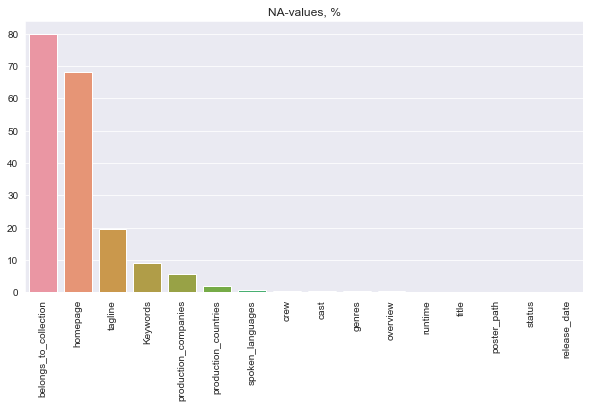

In [6]:
fig = plt.figure(figsize=(10, 5))
na_values = all_data.isna().sum().sort_values(ascending=False)
ax = sns.barplot(x=na_values[na_values > 0].index, y=na_values[na_values > 0]*100/all_data.shape[0]);
plt.title('NA-values, %')
plt.xticks(rotation='vertical');

**NAN FILLING**

Some of Nans we can fill manually. For other it must be used TMDB API.

In [7]:
# https://www.kinopoisk.ru/film/35890/
all_data.at[3828, 'release_date'] = '3/20/01'
# https://www.kinopoisk.ru/film/279040/
all_data.at[1335, 'runtime'] = 130
all_data.at[1335, 'production_countries'] = [{'iso_3166_1': 'RU', 'name': 'Russia'}]

In [11]:
print('Missed values in release_date: ' ,all_data.release_date.isna().sum())

Missed values in release_date:  0


In [12]:
all_data.columns

Index(['index', 'id', 'belongs_to_collection', 'budget', 'genres', 'homepage',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'runtime', 'spoken_languages',
       'status', 'tagline', 'title', 'Keywords', 'cast', 'crew'],
      dtype='object')

Nans that can be filled by API / all nans
* release_date: 0/1
* status: 0/2
* title: 3/3
* runtime: 5/6
* overview: 0/22
* genres: 23/23
* cast: 26/26
* crew: 0/38
* spoken_languages: 0/62
* production_countries: 0/157
* production_companies: 0/414
* Keywords: 0/669

Fill nans in titles.

In [13]:
from imdb import IMDb

imdb = IMDb()
feature_name = 'title'
print(feature_name)
print('Before filling: ', all_data[all_data[feature_name].isna()].shape[0])
for nan_index in all_data[all_data[feature_name].isna()].index:
    try:
        imdb_id = all_data.loc[nan_index, 'imdb_id'][2:]
    except:
        print(nan_index)
        continue
    try:
        movie=imdb.get_movie(imdb_id)
        all_data.at[nan_index, feature_name] = movie[feature_name]
        #print(all_data.loc[nan_index, feature_name])
    except Exception as e:
        print(e)
        pass
print('After filling: ', all_data[all_data[feature_name].isna()].shape[0])

title
Before filling:  3
After filling:  0


Fill nans in runtimes.

In [14]:
feature_name = 'runtime'
nans_for_remove = []
print(feature_name)
print('Before filling: ', all_data[all_data[feature_name].isna()].shape[0])
for nan_index in all_data[all_data[feature_name].isna()].index:
    try:
        imdb_id = all_data.loc[nan_index, 'imdb_id'][2:]
    except:
        nans_for_remove.append(nan_index)
        continue
    try:
        movie=imdb.get_movie(imdb_id)
        all_data.at[nan_index, feature_name] = int(movie[feature_name][0])
        #print(movie[feature_name])
    except Exception as e:
        pass
print('After filling: ', all_data[all_data[feature_name].isna()].shape[0])

runtime
Before filling:  5
After filling:  1


Fill nans in genres.

In [15]:
feature_name = 'genres'
print(feature_name)
print('Before filling: ', all_data[all_data[feature_name].isna()].shape[0])
for nan_index in all_data[all_data[feature_name].isna()].index:
    imdb_id = all_data.loc[nan_index, 'imdb_id'][2:]
    # create string for json
    try:
        s = '['
        movie=imdb.get_movie(imdb_id)
        for genre in movie[feature_name]:
            s += "{'name:' '" + genre + "'}, "
        s = s[:-2] + "]"
        all_data.at[nan_index, feature_name] = s
        #print(all_data.loc[nan_index, feature_name])
    except Exception as e:
        print(e)
print('After filling: ', all_data[feature_name].isna().sum())

genres
Before filling:  23
After filling:  0


Fill nans in casts.

In [16]:
%%time
feature_name = 'cast'
print(feature_name)
print('Before filling: ', all_data[all_data[feature_name].isna()].shape[0])
for nan_index in all_data[all_data[feature_name].isna()].index:
    imdb_id = all_data.loc[nan_index, 'imdb_id'][2:]
    # create string for json
    try:
        s = '['
        movie=imdb.get_movie(imdb_id)
        for actor in movie[feature_name]:
            s += "{'name:' '" + str(actor) + "'}, "
        s = s[:-2] + "]"
        all_data.at[nan_index, feature_name] = s
        #print(s)
    except Exception as e:
        pass
print('After filling: ', all_data[all_data[feature_name].isna()].shape[0])

cast
Before filling:  26
After filling:  0
CPU times: user 19.7 s, sys: 788 ms, total: 20.5 s
Wall time: 1min 48s


In [17]:
print('Results after Nan-filling:\n')
print('Missed values in cast: ', all_data.genres.isna().sum())
print('Missed values in genres: ', all_data.genres.isna().sum())
print('Missed values in titles: ', all_data.title.isna().sum())
print('Missed values in runtimes: ', all_data.runtime.isna().sum())

Results after Nan-filling:

Missed values in cast:  0
Missed values in genres:  0
Missed values in titles:  0
Missed values in runtimes:  1


Let's get some additional features from TMDB. For use it you must get TMDB's API_KEY after registration: https://www.themoviedb.org/faq/api

In [18]:
import tmdbsimple as tmdb
tmdb.API_KEY = 'API_KEY' # your TMDB's API_KEY

TMDB API has constraint to make queries (about 40 ones in 10 seconds), that's why every 6 iterations I make a pause. Procedure takes a lot of precious time, 
so here is an example for only 100 films.

In [19]:
new_data = pd.DataFrame(index=all_data.index, columns=['imdb_id', 'adult', 'budget', 'revenue', 
                                                      'vote_average', 'vote_count', 'video', 
                                                       'status', 'homepage'])
full_year = lambda year: 2000 + year if year < 20 else 1900 + year
release_year = lambda release_data: full_year(int(re.findall('\d+/\d+/(\d+)', release_data)[0]))
all_data['release_year'] = all_data['release_date'].apply(release_year)

i = 0
max_step = 6     # if n_iteration equals max_step => time delay 
for index, row in all_data.loc[:100, :].iterrows():
#     if index % 10 == 0:
#         print(index)
    if i == max_step:
        time.sleep(10.001)
        i = 0
    title = row['title']
    year = row['release_year']
    relevant_imdb_id = row['imdb_id']
    search = tmdb.Search()
    response = search.movie(query=title, year=year)
    for result in response['results']:
        id_ = result['id']
        film = tmdb.Movies(id_)
        film_info = film.info()
        imdb_id = film_info['imdb_id']
        if imdb_id == relevant_imdb_id:
            new_data.at[index, 'imdb_id'] = film_info['imdb_id']
            new_data.at[index, 'budget'] = film_info['budget']
            new_data.at[index, 'adult'] = film_info['adult']
            new_data.at[index, 'vote_average'] = film_info['vote_average']
            new_data.at[index, 'vote_count'] = film_info['vote_count']
            new_data.at[index, 'video'] = film_info['video']
            new_data.at[index, 'revenue'] = film_info['revenue']
            new_data.at[index, 'status'] = film_info['status'] 
            new_data.at[index, 'homepage'] = film_info['homepage']
    i += 1

Get info from jsons with cast.

In [20]:
def trash_replacement(substring):
    temp_str = substring.replace("'", '$$$$')
    temp_str = temp_str.replace('"', '$$$$')
    return temp_str
    
def get_list_for_entry_cast(dataframe, feature_name, field_name):
    if feature_name not in dataframe.columns:
        return 'No feature problem!'  
    feature_with_list = pd.Series(index=dataframe.index)
    nan_index = []
    for index, json_string in enumerate(dataframe[feature_name]):
        entry_list = []
        json_string = json_string.replace("'name:'", "'name':")
        json_string = json_string.replace('\'', '"')
        try: 
            for str_with_apostr in re.findall(":\s*\"(.*?)\"[},]", json_string):
                json_string = json_string.replace(str_with_apostr, trash_replacement(str_with_apostr), 1)
            json_string = json_string.replace('\\', '')
            json_string = json_string.replace('None', '"None"')
            json_string = json_string.replace('$$$$', "'")
           
            entry_jsons = json.loads(json_string)
            
            # I remove all actors with no profiles in TMDB-database
            for entry_json in entry_jsons:
                if 'profile_path' in entry_json.keys():
                    if entry_json['profile_path'] != 'None':
                        entry_list.append(entry_json[field_name])
                else: 
                    entry_list.append(entry_json[field_name])
        except:
            nan_index.append(index)
        finally:
            feature_with_list[index]  =  entry_list
    return feature_with_list, nan_index

* **Language Processing**

Create new features - len_prod_countries and len_spoken_languages.

In [21]:
lang = all_data.loc[:, ['original_language', 'production_countries', 'spoken_languages']]
#lang.at[2992, 'spoken_languages'] = "[{'iso_639_1': 'en', 'name': 'English'}]"
lang['production_countries_list'] = get_list_for_entry(lang, 'production_countries', 'iso_3166_1')[0]
lang['spoken_languages_list'] = get_list_for_entry(lang, 'spoken_languages', 'iso_639_1')[0]
ind = []

for index, value in enumerate(lang.spoken_languages_list):
    if len(value) == 0:
        empty_list = []
        empty_list.append(lang.loc[index, 'original_language'])
        lang.at[index, 'spoken_languages_list'] = empty_list
        ind.append(index)
        
lang['len_prod_countries'] = lang['production_countries_list'].apply(len)

lang.at[lang[lang.len_prod_countries == 0].index, 'len_prod_countries'] = 1
lang['len_spoken_languages'] = lang['spoken_languages_list'].apply(len)
#lang.at[5992, 'spoken_languages_list'] = ['en']

Some of values in languages is 'xx'. It corrects by:

In [22]:
xx_lang_index = []
for i, row in lang.iterrows():
    for language in row['spoken_languages_list']:
        if language == 'xx':
            print(i)
            xx_lang_index.append(i)

605
1161
1304
1763
2323
2577
2992
3119
5925
6193
6407
6831


In [23]:
lang.loc[6407, 'original_language'] = 'fr'
lang.loc[6831, 'original_language'] = 'fr'

for index in xx_lang_index:
    new_orig_lang = []
    new_orig_lang.append(lang.loc[index, 'original_language'])
    lang.at[index, 'spoken_languages_list'] = new_orig_lang

In [24]:
lang.loc[xx_lang_index, :]

,original_language,production_countries,spoken_languages,production_countries_list,spoken_languages_list,len_prod_countries,len_spoken_languages
605,en,"[{'iso_3166_1': 'US', 'name': 'United States o...","[{'iso_639_1': 'xx', 'name': 'No Language'}]",[US],[en],1,1
1161,en,"[{'iso_3166_1': 'US', 'name': 'United States o...","[{'iso_639_1': 'xx', 'name': 'No Language'}]",[US],[en],1,1
1304,fr,"[{'iso_3166_1': 'FR', 'name': 'France'}, {'iso...","[{'iso_639_1': 'xx', 'name': 'No Language'}]","[FR, JP]",[fr],2,1
1763,en,"[{'iso_3166_1': 'US', 'name': 'United States o...","[{'iso_639_1': 'xx', 'name': 'No Language'}]",[US],[en],1,1
2323,fr,"[{'iso_3166_1': 'FR', 'name': 'France'}]","[{'iso_639_1': 'xx', 'name': 'No Language'}]",[FR],[fr],1,1
2577,en,"[{'iso_3166_1': 'US', 'name': 'United States o...","[{'iso_639_1': 'xx', 'name': 'No Language'}]",[US],[en],1,1
2992,en,"[{'iso_3166_1': 'US', 'name': 'United States o...","[{'iso_639_1': 'xx', 'name': 'No Language'}]",[US],[en],1,1
3119,de,"[{'iso_3166_1': 'DE', 'name': 'Germany'}]","[{'iso_639_1': 'xx', 'name': 'No Language'}]",[DE],[de],1,1
5925,en,"[{'iso_3166_1': 'US', 'name': 'United States o...","[{'iso_639_1': 'xx', 'name': 'No Language'}]",[US],[en],1,1
6193,en,"[{'iso_3166_1': 'US', 'name': 'United States o...","[{'iso_639_1': 'xx', 'name': 'No Language'}]",[US],[en],1,1


Visualize the data about languages:

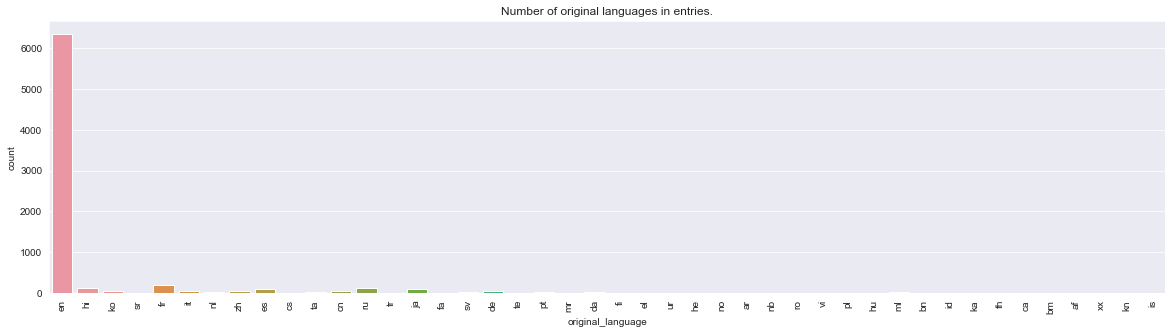

In [25]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 5)
original_languages = all_data.original_language
sns.countplot(original_languages, ax=ax)
plt.title('Number of original languages in entries.')
plt.xticks(rotation='vertical');

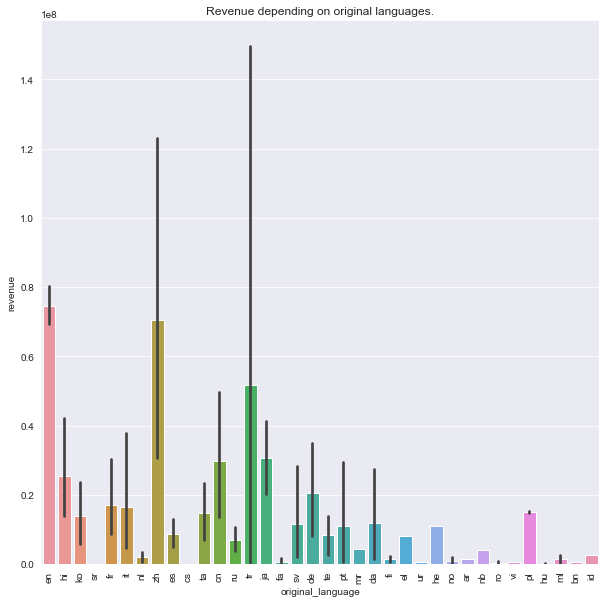

In [26]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
sns.barplot(data=train_data, x='original_language', y='revenue', ax=ax)
plt.title('Revenue depending on original languages.')
plt.xticks(rotation='vertical');

 * **Genres to hot vectors**

Genre is important feature and it must be transformed to one-hot representation.

In [27]:
genres_set = list(get_set_of_fields_from_json(all_data, 'genres', 'name')[0])
genres_hotvec = pd.DataFrame(index=all_data.index, columns=['genre_' + name for name in genres_set])
genres_hotvec.fillna(value=0, inplace=True)

for index_entry, genres_entry in enumerate(get_list_for_entry(all_data, 'genres', 'name')[0]):
    for ganre in genres_entry:
        genres_hotvec.at[index_entry, 'genre_' + ganre] = 1

* **Production_companies**

In [28]:
def create_table(primary_df, column_name, field_in_json, get_list_for_entry=get_list_for_entry):
    if column_name not in primary_df.columns:
        print('Column_name is nat valid.')
        return 0
    table = pd.DataFrame(index=all_data.index)
    table[column_name] = primary_df[column_name]
    table[column_name +'_list'], nans = get_list_for_entry(primary_df, column_name, field_in_json)
    table['len_' + column_name] = table[column_name +'_list'].apply(len)
    # temporary decision
    table.at[table[table['len_' + column_name] == 0].index, 'len_' + column_name] = 1
    return table

In [29]:
print('Amount of unique productions_companies: ', \
      len(get_set_of_fields_from_json(all_data, 'production_companies', 'name')[0]))
print('Nans in production_companies: ', all_data['production_companies'].isna().sum())

Amount of unique productions_companies:  7075
Nans in production_companies:  414


Let's make a new feature - rating that based on budget. For each entity in json (e.g. name of actor or company) 
we calculate mean budget of films where it takes part.  Finally,  result must be arranged in ordering of decreasing.[](http://)

In [30]:
def make_object_rating_fast(primary_df,  # params for primary df
                       df_column_with_object_names, 
                       field_in_json,
                       df_column_for_quality,
                       get_list_for_entry=get_list_for_entry_cast): 
    
    '''Make rating of objects in "df_column_with_object_names" with name "field_in_json" and quality
        measurment by "df_column_for_quality".
    '''
    if (df_column_with_object_names not in primary_df.columns) or (df_column_for_quality not in primary_df):
        print('Column_name is nat valid.')
        return 0
    
    # table where jsons -> lists
    df_with_object_lists = create_table(primary_df, 
                                        df_column_with_object_names, 
                                        field_in_json, get_list_for_entry)
    column_name_for_object_lists = df_column_with_object_names +'_list'
    
    indexes = []
    for x in df_with_object_lists[column_name_for_object_lists]:
        indexes = indexes + x
    rating_of_objects = pd.DataFrame(index=set(indexes),
                                     columns=['number_of_entries_with_object', 
                                              'summary_object_quality', 
                                              'mean_quality'])
    rating_of_objects.at[rating_of_objects.index, rating_of_objects.columns] = 0
    
    # count films with object take part in
    for record_id in primary_df.index:
        for object_name in df_with_object_lists.loc[record_id, column_name_for_object_lists]:
                rating_of_objects.at[object_name, 'number_of_entries_with_object'] += 1
                rating_of_objects.at[object_name, 'summary_object_quality'] += \
                    primary_df.loc[record_id, df_column_for_quality]
    
    # normalization
    for object_name in rating_of_objects.index:
        if rating_of_objects.loc[object_name, 'number_of_entries_with_object'] > 0:
            rating_of_objects.at[object_name, 'mean_quality'] = rating_of_objects.loc[object_name, \
                'summary_object_quality'] / rating_of_objects.loc[object_name, 'number_of_entries_with_object']
    
    # sort result and make rating
    unique_values = sorted(set(rating_of_objects.mean_quality.values), reverse=True)
    dict_quality = {unique_values[index]: index + 1 for index in range(len(unique_values))}
    rate_objects_func = lambda x: dict_quality[x]
    rating_of_objects['rating'] = rating_of_objects['mean_quality'].apply(rate_objects_func)
    
    get_rating_list_func = lambda array: [rating_of_objects.loc[object_name, 'rating'] \
                                for object_name in array] if len(array) > 0 else len(unique_values) + 1
    df_with_object_lists['rating_list'] = df_with_object_lists[column_name_for_object_lists] \
                                                .apply(get_rating_list_func)
    df_with_object_lists['result_mean_rating'] = df_with_object_lists['rating_list'].apply(np.mean)
    return  rating_of_objects, dict_quality, df_with_object_lists

* **Crew**

In [31]:
print('Nans in crew: ', all_data[all_data.crew.isna()].shape[0])

Nans in crew:  38


Get info from jsons with crew.

In [32]:
def get_crew_names(department_name, job_name):
    df_for_output = pd.DataFrame(index=all_data.index, columns=[job_name])
    for index, json_string in enumerate(all_data.crew.fillna(value='[]')):
        for str_with_apostr in re.findall('"([^\"]+)"', json_string):
            string_with_replaced_quote = str_with_apostr.replace("'", '$$$')
            json_string = json_string.replace(str_with_apostr, string_with_replaced_quote)
        for str_with_apostr in re.findall("'([^\']+)'", json_string):
            string_with_replaced_quote = str_with_apostr.replace('"', '')
            json_string = json_string.replace(str_with_apostr, string_with_replaced_quote)

        json_string = json_string.replace("\'", '"')
        json_string = json_string.replace('None', '"None"')
        json_string = json_string.replace('$$$', "'")

        entry_jsons = json.loads(json_string)
        crew_names = []
        for crew_member_json in entry_jsons:
            if crew_member_json['department'] == department_name and crew_member_json['job'] == job_name:
                crew_names.append(crew_member_json['name'])
        df_for_output.at[index, job_name] = crew_names
    return df_for_output

In [33]:
directors = get_crew_names('Directing', 'Director')
producers = get_crew_names('Production', 'Producer')

Generate rating of crew.

In [36]:
def get_crew_rating(primary_df, df_column_for_quality, df_with_object_lists, job_name):    
    df_for_return = df_with_object_lists.copy()
    indexes = []
    for x in df_with_object_lists[job_name]:
        indexes = indexes + x
    rating_of_objects = pd.DataFrame(index=set(indexes),
                                     columns=['number_of_entries_with_object', 
                                              'summary_object_quality', 
                                              'mean_quality'],
                                     dtype='float')
    rating_of_objects.at[rating_of_objects.index, rating_of_objects.columns] = 0.0   
    for record_id in primary_df.index:
        for object_name in df_with_object_lists.loc[record_id, job_name]:
                rating_of_objects.at[object_name, 'number_of_entries_with_object'] += 1
                rating_of_objects.at[object_name, 'summary_object_quality'] += \
                    primary_df.loc[record_id, df_column_for_quality]

    for object_name in rating_of_objects.index:
        if rating_of_objects.loc[object_name, 'number_of_entries_with_object'] > 0.0:
            rating_of_objects.at[object_name, 'mean_quality'] = \
                rating_of_objects.loc[object_name, 'summary_object_quality'] / rating_of_objects.loc[object_name, 'number_of_entries_with_object']

    unique_values = sorted(set(rating_of_objects.mean_quality.values), reverse=True)
    dict_quality = {unique_values[index]: index + 1 for index in range(len(unique_values))}
    rate_objects_func = lambda x: dict_quality[x]
    rating_of_objects['rating'] = rating_of_objects['mean_quality'].apply(rate_objects_func)

    get_rating_list_func = lambda array: [rating_of_objects.loc[object_name, 'rating'] \
                                for object_name in array] if len(array) > 0 else len(unique_values) + 1
    df_for_return['rating_list'] = df_for_return[job_name].apply(get_rating_list_func)
    df_for_return['result_mean_rating'] = df_for_return['rating_list'].apply(np.mean)
    return  rating_of_objects, dict_quality, df_for_return

* **New Data**

This is additional info from API.

In [39]:
new_data = pd.read_csv('imdb.csv', index_col='Unnamed: 0')

In [40]:
new_data.describe()

,budget,revenue,vote_average,vote_count
count,7.379000e+03,7.379000e+03,7379.000000,7379.000000
mean,2.264761e+07,6.881733e+07,6.339287,976.340968
std,3.685673e+07,1.466649e+08,0.981221,1900.449882
min,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,0.000000e+00,2.281044e+06,5.800000,69.000000
50%,8.000000e+06,1.665612e+07,6.400000,277.000000
75%,2.800000e+07,6.718782e+07,7.000000,938.000000
max,3.800000e+08,2.787965e+09,9.000000,21865.000000


That is why the competition was doomed to dishonest decisions: revenues is already here!
My disappointment knew no bounds.
We are not clowns and will not use target for getting higher place in leaderboard.

In [41]:
cat_features = list(all_data.select_dtypes(['object']).columns)
num_features = list(set(all_data.columns) - set(cat_features) - set(['index', 'release_year', 'id']))

Create transformed dataset.

In [42]:
full_year = lambda year: 2000 + year if year < 20 else 1900 + year  
release_day = lambda release_data: int(re.findall('\d+/(\d+)/\d+', release_data)[0])
release_month = lambda release_data: int(re.findall('(\d+)/\d+/\d+', release_data)[0])
release_year = lambda release_data: full_year(int(re.findall('\d+/\d+/(\d+)', release_data)[0]))

construct_data = pd.DataFrame(index=all_data.index)
construct_data['release_day'] = all_data['release_date'].apply(release_day)
construct_data['release_month'] = all_data['release_date'].apply(release_month)
construct_data['release_year'] = all_data['release_date'].apply(release_year)
construct_data['homepage_bool'] = (all_data.homepage.isna() ^ True).astype(int) 
construct_data['belongs_to_collections_bool'] = (all_data.belongs_to_collection.isna() ^ True).astype(int)
construct_data['original_language'] = lang['original_language']
construct_data['len_prod_countries'] = lang['len_prod_countries']
construct_data['len_spoken_languages'] = lang['len_spoken_languages']
construct_data['vote_average'] = new_data['vote_average'].fillna(value=new_data['vote_average'].median())
construct_data['vote_count'] = new_data['vote_count'].fillna(value=new_data.vote_average.median())


construct_data = pd.concat([construct_data, genres_hotvec], axis=1)
construct_data = pd.concat([construct_data, all_data.loc[:, num_features]], axis=1)
# runtime is in num_features
construct_data['runtime'] = construct_data['runtime'].fillna(value=np.ceil(construct_data['runtime'].mean()))
construct_data['runtime'] = construct_data['runtime'].replace({0: np.ceil(construct_data.runtime.mean())})
construct_data = pd.get_dummies(construct_data, columns=['original_language'])

Inflation is significant factor! Use cpi module for calculation analogue of cost in 2018 for all films.

In [43]:
# value, year in params
adjust_by_inflation = lambda x: cpi.inflate(value=x[0], year_or_month=int(x[1]), to=2018) 
construct_data['budget_adjusted_by_inflation'] = construct_data.loc[:, ['budget', 'release_year']] \
                                                                    .apply(adjust_by_inflation, axis=1)

In [44]:
old_budget_from_construct = construct_data['budget']
construct_data = construct_data.drop(['budget'], axis=1)

Add new features. This idea is not mine=)

In [45]:
construct_data['budget_2018_runtime_ratio'] = construct_data['budget_adjusted_by_inflation'] / \
                                                  construct_data['runtime'] 
construct_data['budget_2018_popularity_ratio'] = construct_data['budget_adjusted_by_inflation'] / \
                                                  construct_data['popularity']
construct_data['budget_2018_year_ratio'] = construct_data['budget_adjusted_by_inflation'] / \
                                               (construct_data['release_year']*construct_data['release_year'])

construct_data['release_year_popularity_ratio'] = construct_data['release_year'] / construct_data['popularity']
construct_data['popularity_release_year_ratio'] = construct_data['popularity'] / construct_data['release_year']

mean_budget_2018_by_year = construct_data.groupby("release_year")["budget_adjusted_by_inflation"].aggregate('mean')
mean_popularity_by_year = construct_data.groupby("release_year")["popularity"].aggregate('mean')
mean_runtime_by_year = construct_data.groupby("release_year")["runtime"].aggregate('mean')
construct_data['mean_budget_2018_by_year'] = [mean_budget_2018_by_year[i] for i in construct_data.release_year]
construct_data['mean_popularity_by_year'] = [mean_popularity_by_year[i] for i in construct_data.release_year]
construct_data['mean_runtime_by_year'] = [mean_runtime_by_year[i] for i in construct_data.release_year]

construct_data['vote_count_popularity_ratio'] = construct_data['vote_count'] / construct_data['popularity']
construct_data['vote_count_release_year_ratio'] = construct_data['vote_count'] / construct_data['release_year']
construct_data['budget_2018_vote_count_ratio'] = construct_data['budget_adjusted_by_inflation'] / \
                                                     construct_data['vote_count']
construct_data['budget_2018_vote_count_ratio'] = construct_data['budget_2018_vote_count_ratio'].fillna(value=0)
construct_data['budget_2018_vote_count_ratio'] = construct_data['budget_2018_vote_count_ratio'].replace({np.inf: 0})

In [46]:
all_data['budget_adjusted_by_inflation'] = construct_data['budget_adjusted_by_inflation']
vote_average = new_data['vote_average']
vote_average = vote_average.fillna(value=vote_average.median()) 
vote_average.reset_index(drop=True, inplace=True)
all_data.reset_index(drop=True, inplace=True)
all_data = pd.concat([vote_average, all_data], axis=1)
all_data['cast'] = all_data.cast.fillna(value='')

Calculation ratings of collection, production_companies, cast, crew by popularity, votes, budget. 

In [47]:
%%time
collections_rating_by_budget_2018, dict_collections_quality_by_budget_2018, collections_by_budget_2018  = \
                    make_object_rating_fast(all_data, 
                                           'belongs_to_collection', 
                                           'name',
                                           'budget_adjusted_by_inflation',
                                           get_list_for_entry)

prod_companies_rating_by_budget_2018, dict_prod_comp_quality_by_budget_2018, prod_companies_by_budget_2018 = \
                    make_object_rating_fast(all_data, 
                                           'production_companies', 
                                           'name',
                                           'budget_adjusted_by_inflation',
                                           get_list_for_entry)

CPU times: user 3.59 s, sys: 33.1 ms, total: 3.63 s
Wall time: 3.66 s


In [48]:
%%time
collections_rating_by_vote, dict_collections_quality_by_vote, collections_by_vote = \
                    make_object_rating_fast(all_data, 
                                           'belongs_to_collection', 
                                           'name',
                                           'vote_average',
                                           get_list_for_entry)

prod_companies_rating_by_vote, dict_prod_comp_quality_by_vote, prod_companies_by_vote = \
                    make_object_rating_fast(all_data, 
                                           'production_companies', 
                                           'name',
                                           'vote_average',
                                           get_list_for_entry)

CPU times: user 3.61 s, sys: 33.7 ms, total: 3.64 s
Wall time: 3.7 s


In [51]:
%%time
collections_rating_by_popularity, dict_collections_quality_by_popularity, collections_by_popularity  = \
        make_object_rating_fast(all_data, 
                               'belongs_to_collection',                                                                                                                                
                               'name',
                               'popularity',
                               get_list_for_entry)

prod_companies_rating_by_popularity, dict_prod_comp_quality_by_popularity, prod_companies_by_popularity = \
        make_object_rating_fast(all_data, 
                               'production_companies', 
                               'name',
                               'popularity',
                               get_list_for_entry)

CPU times: user 3.51 s, sys: 19.9 ms, total: 3.53 s
Wall time: 3.55 s


In [52]:
%%time
actors_rating_by_budget_2018, dict_actors_quality_by_budget_2018, actors_by_budget_2018 = \
                    make_object_rating_fast(all_data, 
                                           'cast', 
                                           'name',
                                           'budget_adjusted_by_inflation',
                                           get_list_for_entry_cast)

actors_rating_by_vote, dict_actors_quality_by_vote, actors_by_vote = \
                    make_object_rating_fast(all_data, 
                                           'cast', 
                                           'name',
                                           'vote_average',
                                           get_list_for_entry_cast)

actors_rating_by_popularity, dict_actors_quality_by_popularity, actors_by_popularity = \
                    make_object_rating_fast(all_data, 
                                           'cast', 
                                           'name',
                                           'popularity',
                                           get_list_for_entry_cast)

CPU times: user 1min 6s, sys: 1.03 s, total: 1min 7s
Wall time: 1min 10s


In [53]:
director_rating_by_budget_2018, dict_director_rating_by_budget_2018, directors_by_budget_2018 = \
    get_crew_rating(all_data, 'budget_adjusted_by_inflation', directors, 'Director')
producer_rating_by_budget_2018, dict_producer_rating_by_budget_2018, producers_by_budget_2018 = \
    get_crew_rating(all_data, 'budget_adjusted_by_inflation', producers, 'Producer')
director_rating_by_vote, dict_director_rating_by_vote, directors_by_vote = \
    get_crew_rating(all_data, 'vote_average', directors, 'Director')
producer_rating_by_vote, dict_producer_rating_by_vote, producers_by_vote = \
    get_crew_rating(all_data, 'vote_average', producers, 'Producer')
director_rating_by_popularity, dict_director_rating_by_popularity, directors_by_popularity = \
    get_crew_rating(all_data, 'popularity', directors, 'Director')
producer_rating_by_popularity, dict_producer_rating_by_popularity, producers_by_popularity = \
    get_crew_rating(all_data, 'popularity', producers, 'Producer')

Add new features in data.

In [54]:
construct_data['prod_company_rating_by_budget_2018'] = prod_companies_by_budget_2018['result_mean_rating']
construct_data['prod_company_rating_by_vote'] = prod_companies_by_vote['result_mean_rating']
construct_data['prod_company_rating_by_popularity'] = prod_companies_by_popularity['result_mean_rating']
construct_data['len_production_companies'] = prod_companies_by_budget_2018['len_production_companies']

construct_data['actors_rating_by_budget_2018'] = actors_by_budget_2018['result_mean_rating']
construct_data['actors_rating_by_vote'] = actors_by_vote['result_mean_rating']
construct_data['actors_rating_by_popularity'] = actors_by_popularity['result_mean_rating']
construct_data['len_cast'] = actors_by_budget_2018['len_cast']

construct_data['collections_rating_by_budget_2018'] = collections_by_budget_2018['result_mean_rating']
construct_data['collections_rating_by_vote'] = collections_by_vote['result_mean_rating']
construct_data['collections_rating_by_popularity'] = collections_by_popularity['result_mean_rating']

construct_data['directors_rating_by_budget_2018'] = directors_by_budget_2018['result_mean_rating']
construct_data['directors_rating_by_vote'] = directors_by_vote['result_mean_rating']
construct_data['directors_rating_by_popularity'] = directors_by_popularity['result_mean_rating']

construct_data['producers_rating_by_budget_2018'] = producers_by_budget_2018['result_mean_rating']
construct_data['producers_rating_by_vote'] = producers_by_vote['result_mean_rating']
construct_data['producers_rating_by_popularity'] = producers_by_popularity['result_mean_rating']

Modify target by inflation impact.

In [55]:
target_for_adjust = pd.concat([train_data.revenue, construct_data.release_year], axis=1).loc[:2999, :]
adjust_by_inflation = lambda x: cpi.inflate(value=x[0], year_or_month=int(x[1]), to=2018)
target_adjusted_by_inflation = target_for_adjust.apply(adjust_by_inflation, axis=1)

We must went back to revenue in year of film production.

In [56]:
def readjust_target(values_2018, years):
    readjust_by_inflation = lambda x: cpi.inflate(value=x[0], year_or_month=2018, to=int(x[1]))
    # for DF - [:n] is [0, ... , n]
    # for Series - [:n] is [0, ..., n-1]
    data = pd.concat([values_2018, years], axis=1)
    return data.apply(readjust_by_inflation, axis=1)

**FEATURE PREPROCESSING**

In [57]:
train_construct_data = construct_data.loc[:2999, :]
#target = np.log(train_data.revenue)
target = np.log(target_adjusted_by_inflation)
test_construct_data = construct_data.loc[3000:, :]

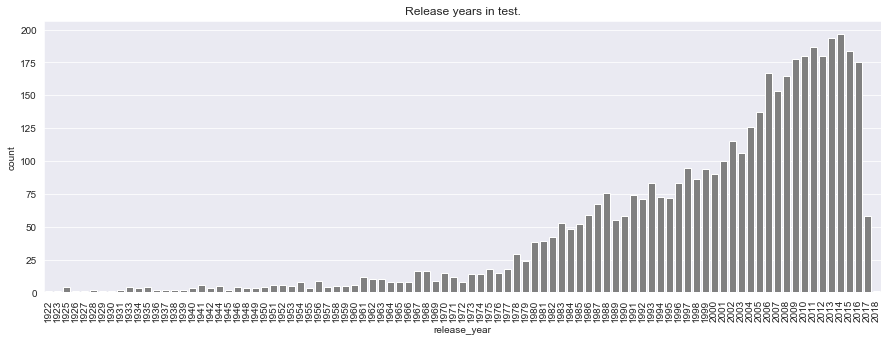

In [58]:
figure = plt.figure(figsize=(15, 5))
sns.countplot(test_construct_data.release_year, color='gray')
plt.title('Release years in test.')
plt.xticks(rotation='vertical');

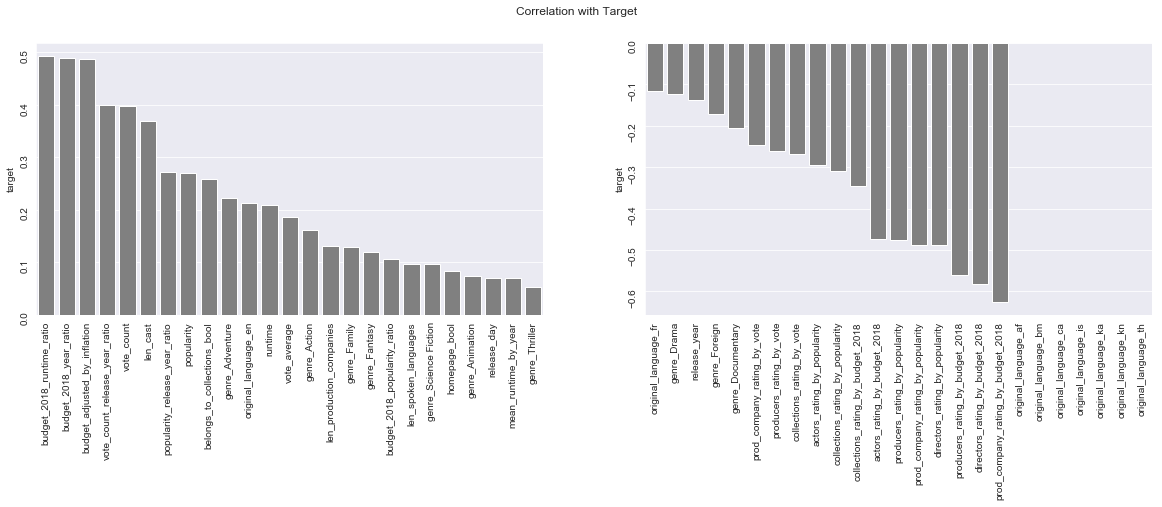

In [59]:
plot_correlation(train_construct_data, target);

Many of added features is important!

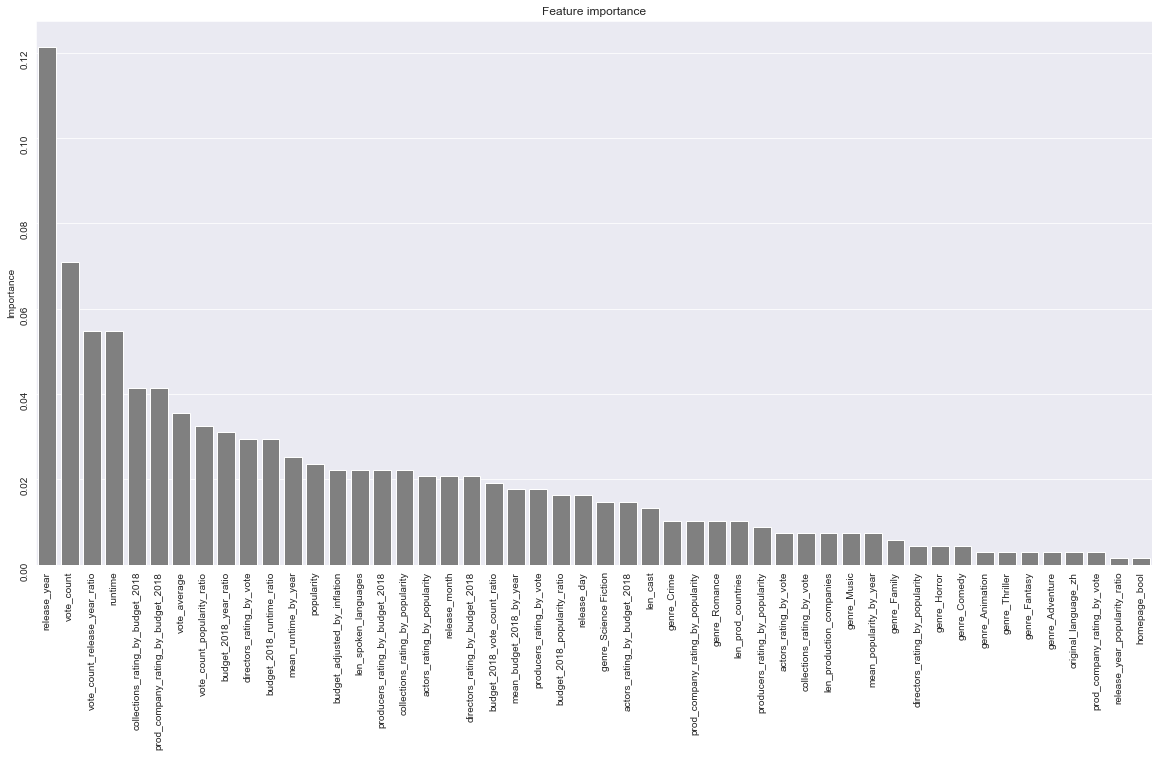

In [60]:
feature_importances(estimator=XGBRegressor(booster='gbtree', random_state=42), 
                    X=train_construct_data, 
                    y=target_adjusted_by_inflation, 
                    plot_flag=True, 
                    n_features_return=50);

We must keep close eye to next features:

In [61]:
features_for_analysis = [name for name in list(construct_data.columns) if ('genre_' not in name) \
                         and ('original_language_' not in name)]
features_for_analysis

['release_day',
 'release_month',
 'release_year',
 'homepage_bool',
 'belongs_to_collections_bool',
 'len_prod_countries',
 'len_spoken_languages',
 'vote_average',
 'vote_count',
 'popularity',
 'runtime',
 'budget_adjusted_by_inflation',
 'budget_2018_runtime_ratio',
 'budget_2018_popularity_ratio',
 'budget_2018_year_ratio',
 'release_year_popularity_ratio',
 'popularity_release_year_ratio',
 'mean_budget_2018_by_year',
 'mean_popularity_by_year',
 'mean_runtime_by_year',
 'vote_count_popularity_ratio',
 'vote_count_release_year_ratio',
 'budget_2018_vote_count_ratio',
 'prod_company_rating_by_budget_2018',
 'prod_company_rating_by_vote',
 'prod_company_rating_by_popularity',
 'len_production_companies',
 'actors_rating_by_budget_2018',
 'actors_rating_by_vote',
 'actors_rating_by_popularity',
 'len_cast',
 'collections_rating_by_budget_2018',
 'collections_rating_by_vote',
 'collections_rating_by_popularity',
 'directors_rating_by_budget_2018',
 'directors_rating_by_vote',
 'direc

Plot correlations betweeen features:

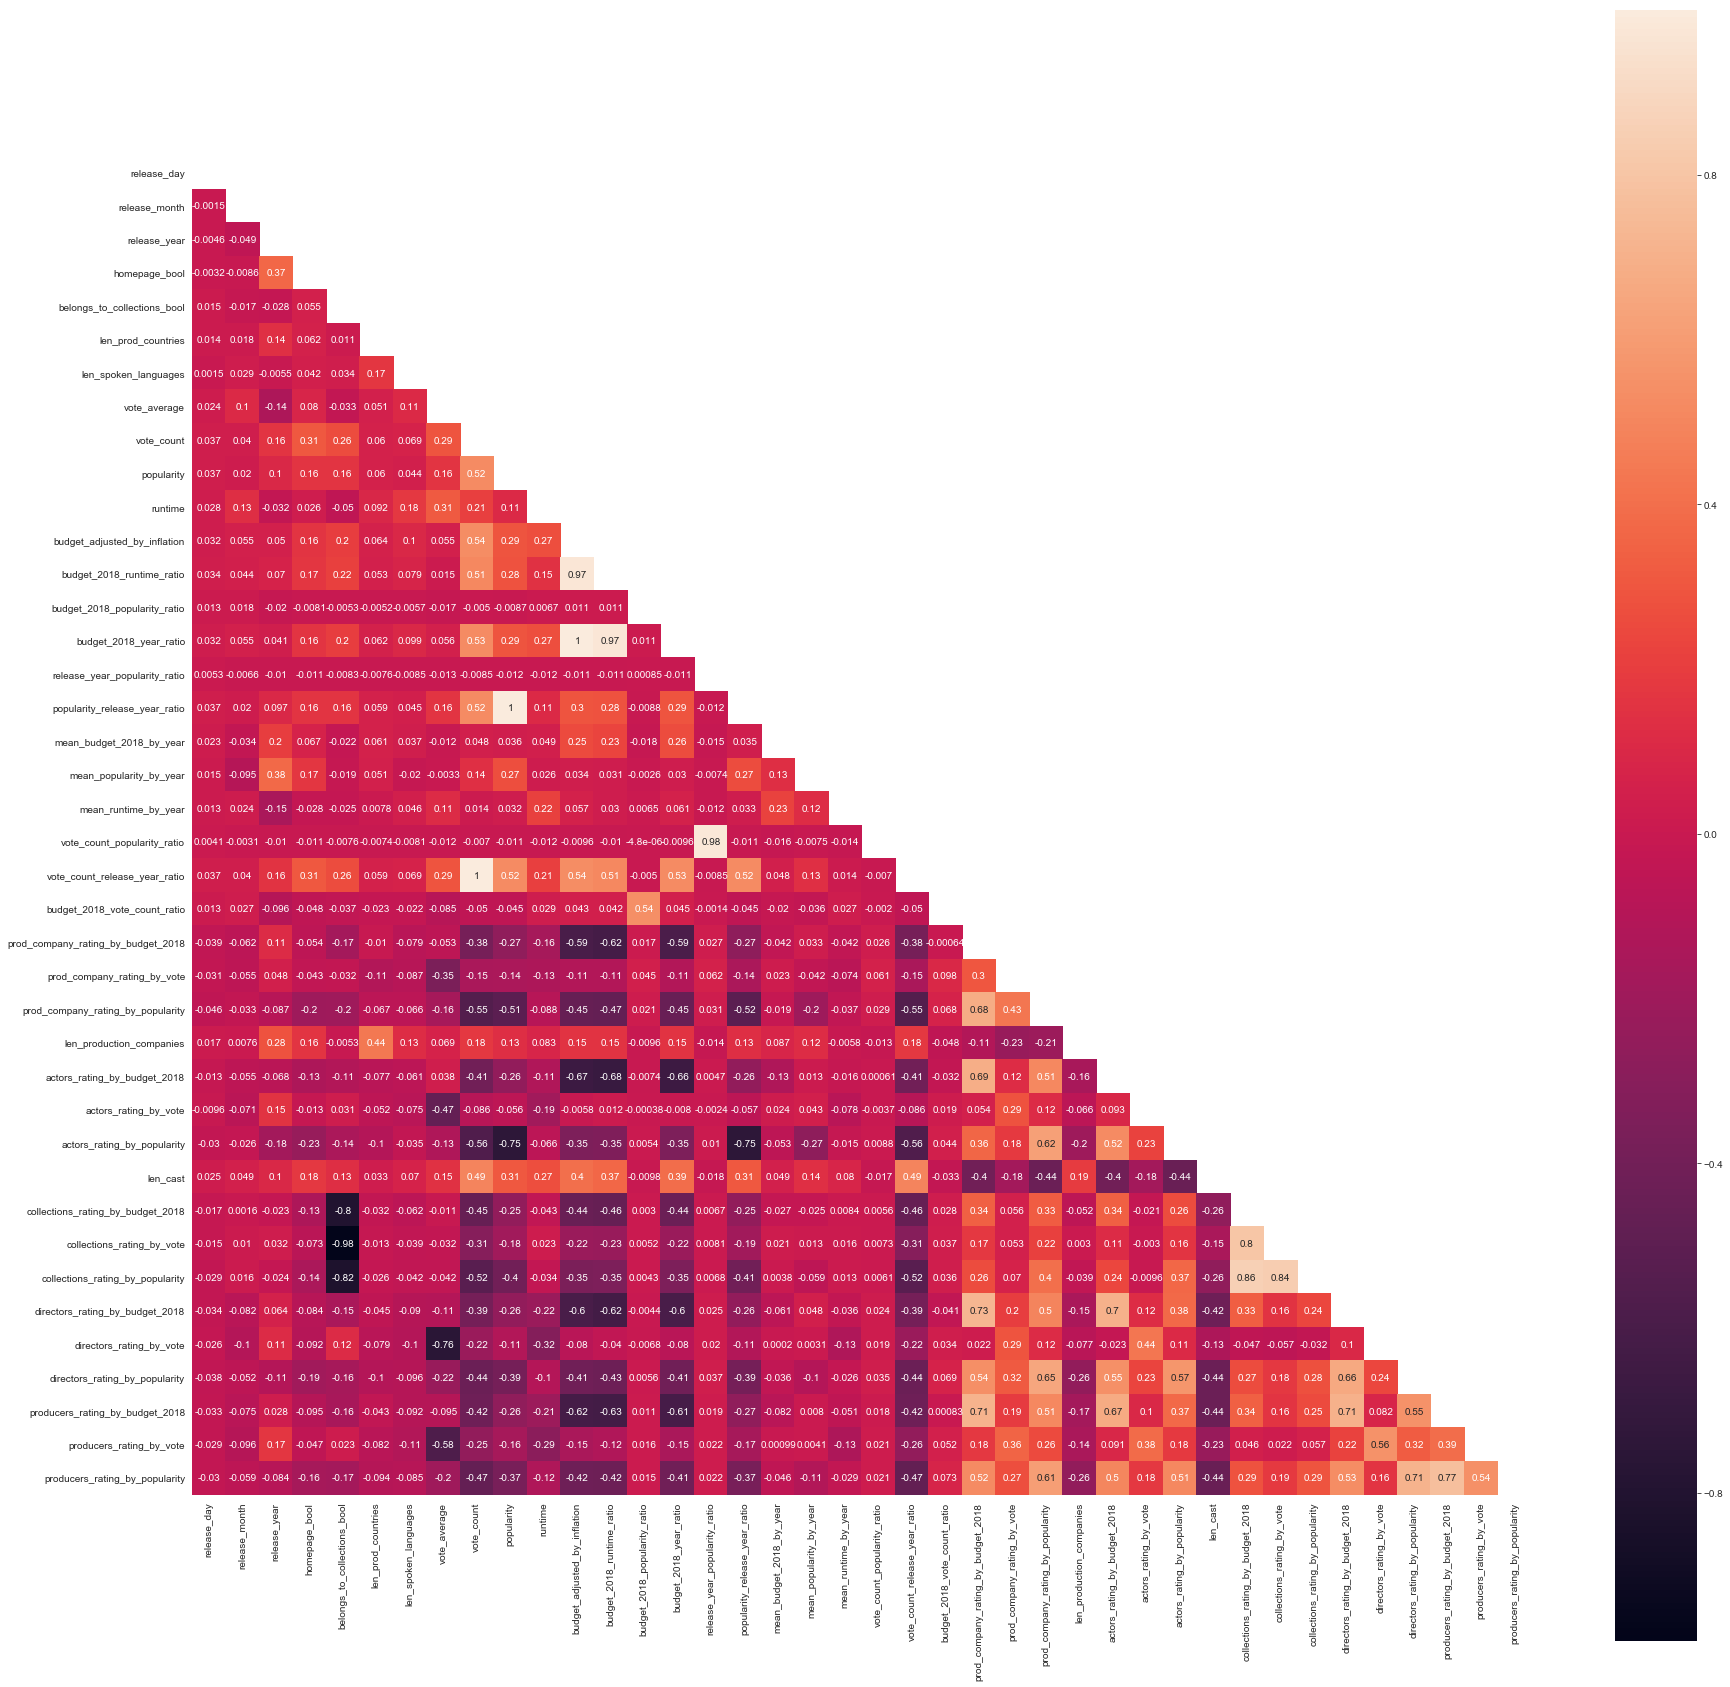

In [62]:
corr = construct_data.loc[:, features_for_analysis].corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    fig = plt.figure(figsize=(30, 30)) 
    sns.heatmap(corr, mask=mask, vmax=1, square=True, annot=True)

Output the beggining and the end of training and testing data.

In [63]:
print('TRAIN DATA: length {}'.format(train_data.shape))
print(train_data['id'].head(3))
print(train_data['id'].tail(3))
print()

print('TEST DATA: length {}'.format(test_data.shape))
print(test_data['id'].head(3))
print(test_data['id'].tail(3))
print(test_data['id'].shape)

TRAIN DATA: length (3000, 23)
0    1
1    2
2    3
Name: id, dtype: int64
2997    2998
2998    2999
2999    3000
Name: id, dtype: int64

TEST DATA: length (4398, 22)
0    3001
1    3002
2    3003
Name: id, dtype: int64
4395    7396
4396    7397
4397    7398
Name: id, dtype: int64
(4398,)


In [64]:
print('==============================================================')
print('TRAIN DATA: new length {}'.format(train_construct_data.shape))
print('TARGET: {}'.format(target.shape))
print(train_construct_data.head(3))
print(train_construct_data.tail(3))
print()

print('TEST DATA: new length {}'.format(test_construct_data.shape))
print(test_construct_data.head(3))
print(test_construct_data.tail(3))
print(test_construct_data.shape)

TRAIN DATA: new length (3000, 103)
TARGET: (3000,)
   release_day  release_month  release_year  homepage_bool  \
0           20              2          2015              0   
1            6              8          2004              0   
2           10             10          2014              1   

   belongs_to_collections_bool  len_prod_countries  len_spoken_languages  \
0                            1                   1                     1   
1                            1                   1                     1   
2                            0                   1                     1   

   vote_average  vote_count  genre_Romance  ...  len_cast  \
0           5.1       498.0              0  ...        22   
1           6.4      1663.0              1  ...        19   
2           8.4      7758.0              0  ...        20   

   collections_rating_by_budget_2018  collections_rating_by_vote  \
0                              329.0                         4.0   
1             

Depending Revenue from Budget and Runtime in training data.

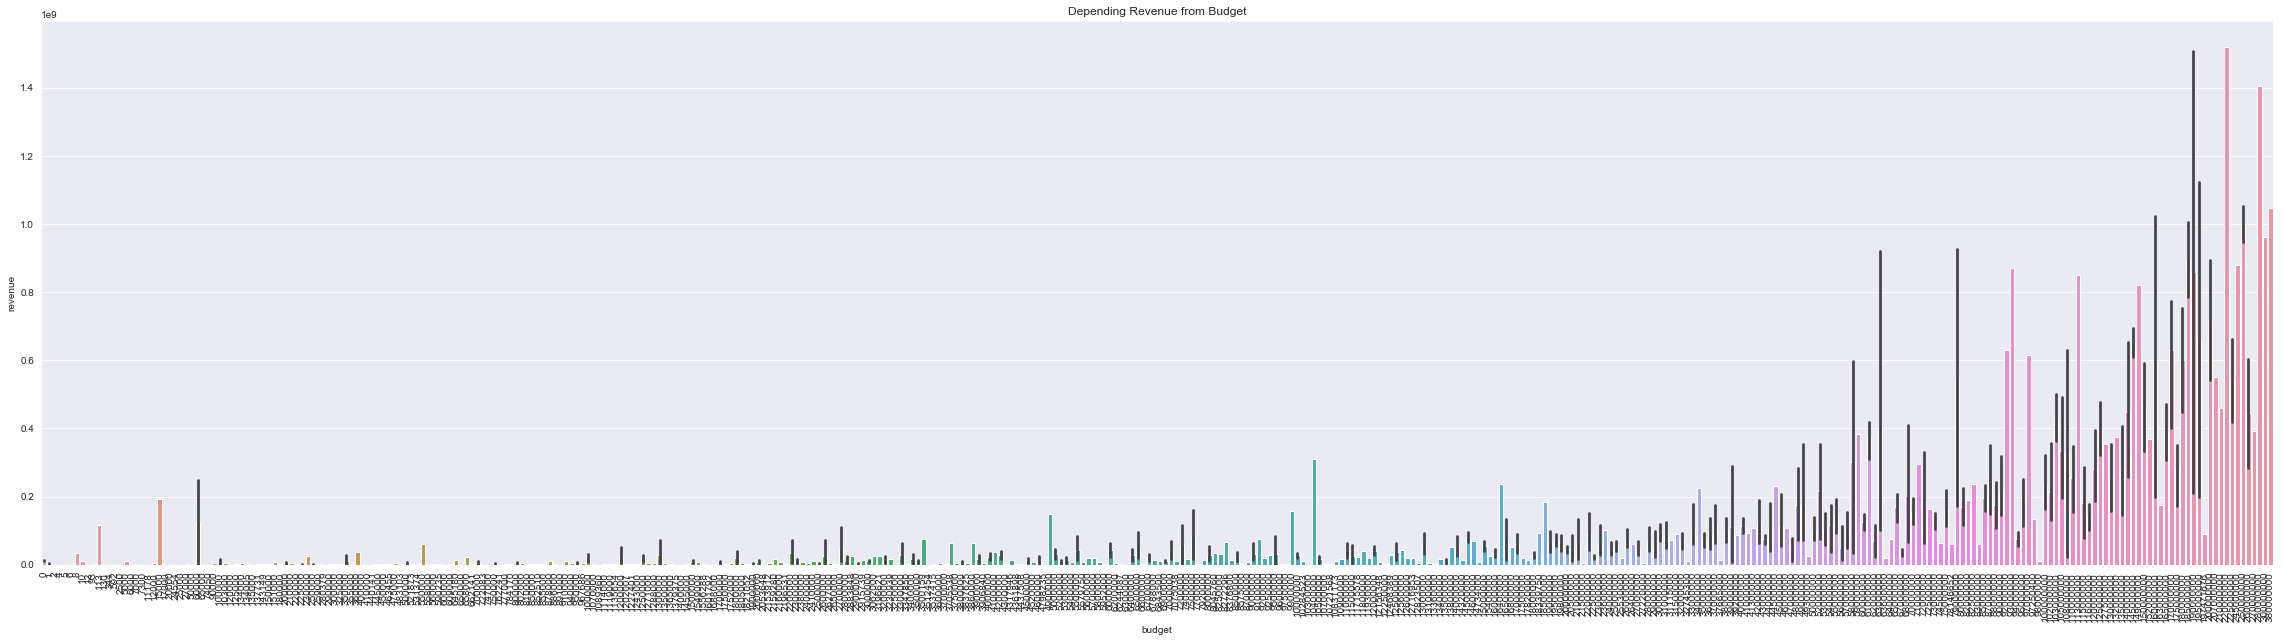

In [65]:
fig, ax = plt.subplots()
fig.set_size_inches(40, 10)
sns.barplot(data=train_data, x='budget', y='revenue', ax=ax)
plt.title('Depending Revenue from Budget')
plt.xticks(rotation='vertical');

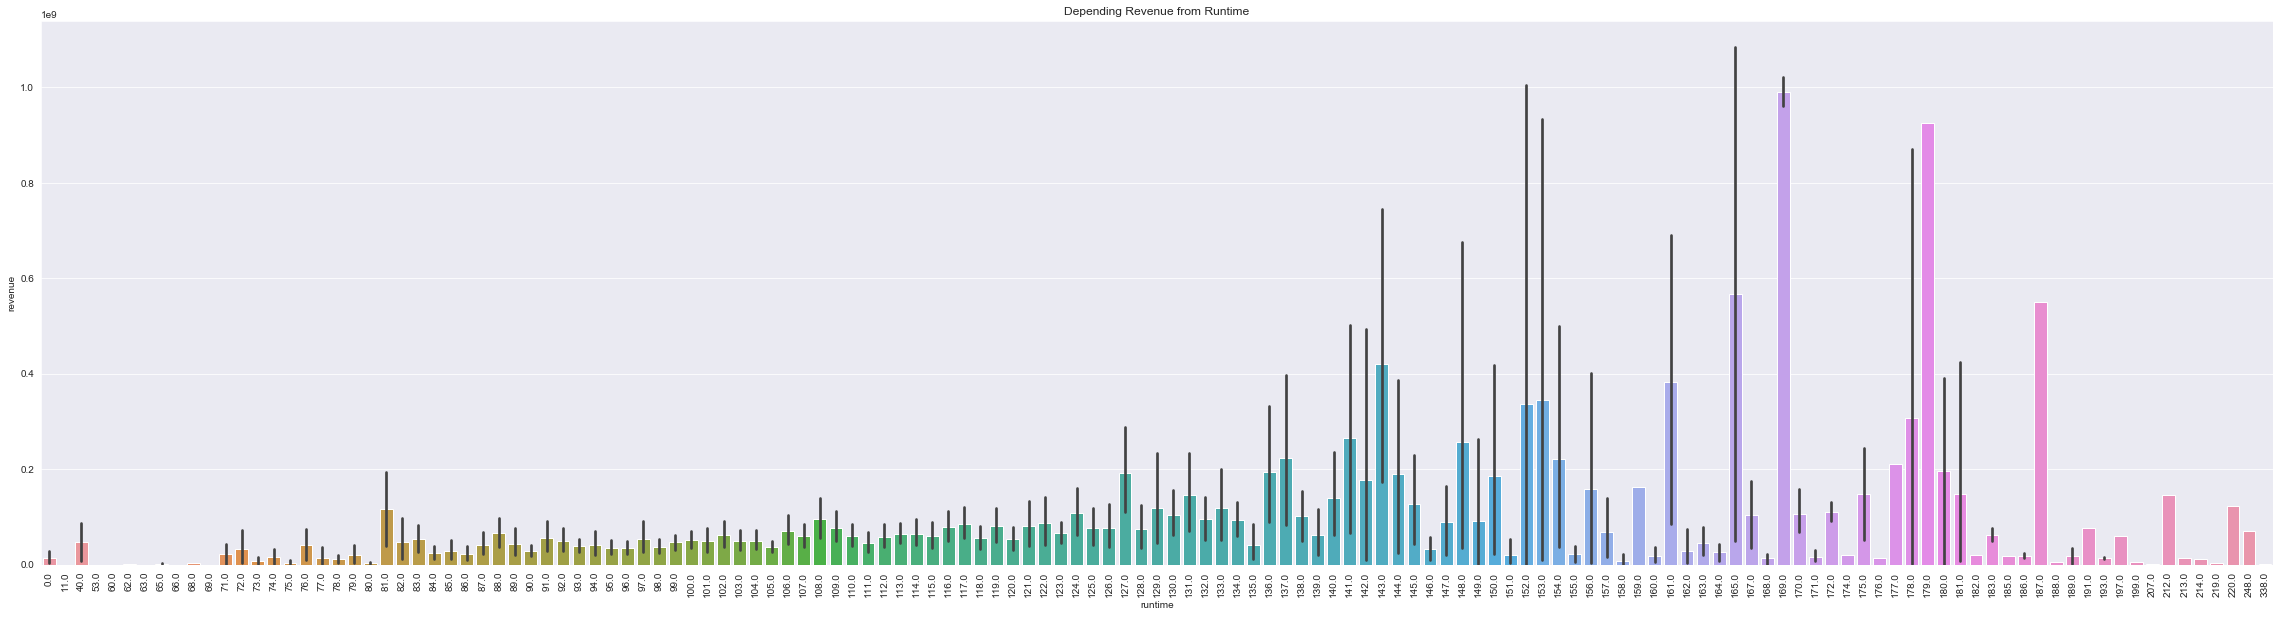

In [66]:
fig, ax = plt.subplots()
fig.set_size_inches(40, 10)
sns.barplot(data=train_data, x='runtime', y='revenue', ax=ax)
plt.title('Depending Revenue from Runtime')
plt.xticks(rotation='vertical');

In [67]:
# add seasons

season_dic = {12: 'winter', 1: 'winter', 2: 'winter',
              3: 'spring', 4: 'spring', 5: 'spring',
              6: 'summer', 7: 'summer', 8: 'summer',
              9: 'autumn', 10: 'autumn', 11: 'autumn'}
construct_data['season_release'] = construct_data['release_month'].replace(season_dic)
construct_data = pd.get_dummies(construct_data, columns=['season_release'])

In [68]:
print('Nans: ', construct_data.isna().sum().sum())
print('Infs: ', construct_data.apply(np.isinf, axis=0).sum().sum())

Nans:  0
Infs:  0


In [69]:
construct_data.head()

,release_day,release_month,release_year,homepage_bool,belongs_to_collections_bool,len_prod_countries,len_spoken_languages,vote_average,vote_count,genre_Romance,...,directors_rating_by_budget_2018,directors_rating_by_vote,directors_rating_by_popularity,producers_rating_by_budget_2018,producers_rating_by_vote,producers_rating_by_popularity,season_release_autumn,season_release_spring,season_release_summer,season_release_winter
0,20,2,2015,0,1,1,1,5.1,498.0,0,...,875.0,394.0,1055.0,2046.000000,569.0,2028.000000,0,0,0,1
1,6,8,2004,0,1,1,1,6.4,1663.0,1,...,644.0,332.0,1183.0,1014.666667,307.0,2660.333333,0,0,1,0
2,10,10,2014,1,0,1,1,8.4,7758.0,0,...,1097.0,8.0,17.0,2624.000000,247.0,182.250000,1,0,0,0
3,9,3,2012,1,0,1,2,7.5,122.0,0,...,1970.0,47.0,2485.0,3150.000000,49.0,4188.000000,0,1,0,0
4,5,2,2009,0,0,1,1,5.7,9.0,0,...,2191.0,416.0,3004.0,3331.000000,688.0,4768.000000,0,0,0,1


In [70]:
features_for_plot = []
for feature_name in features_for_analysis:
    if ('release_' not in feature_name) and ('_bool' not in feature_name):
        features_for_plot.append(feature_name)

Plot distribution of interesting features for train/test and compare.

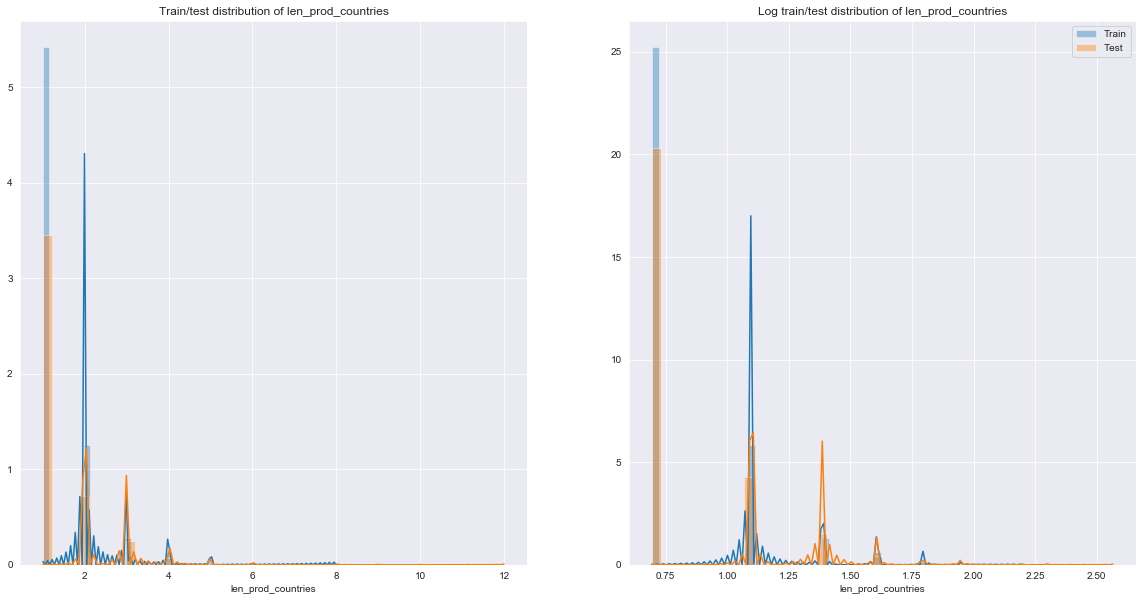

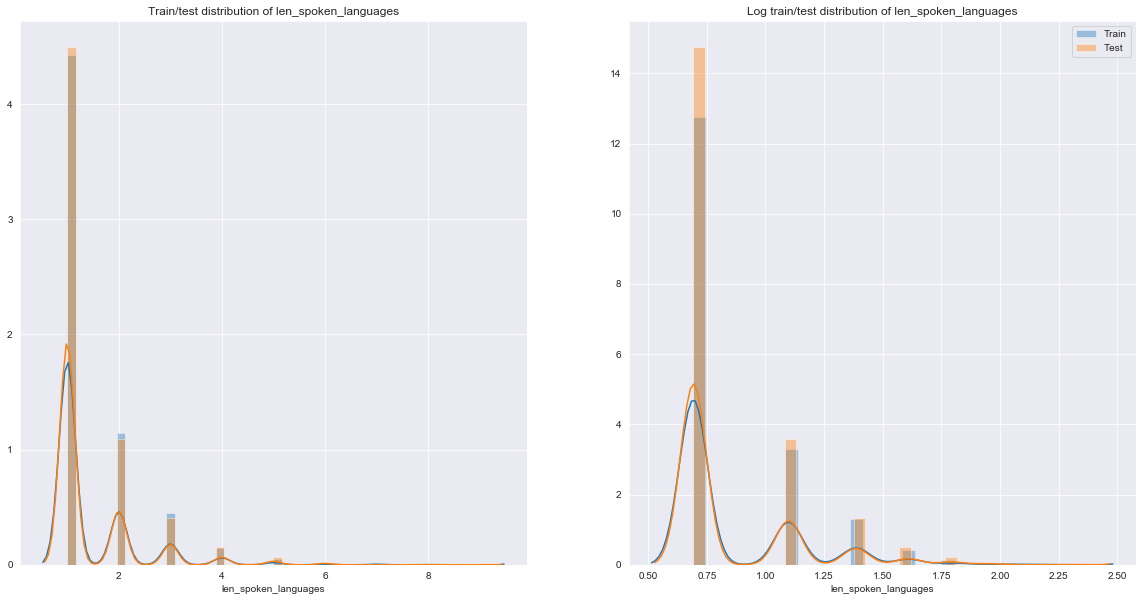

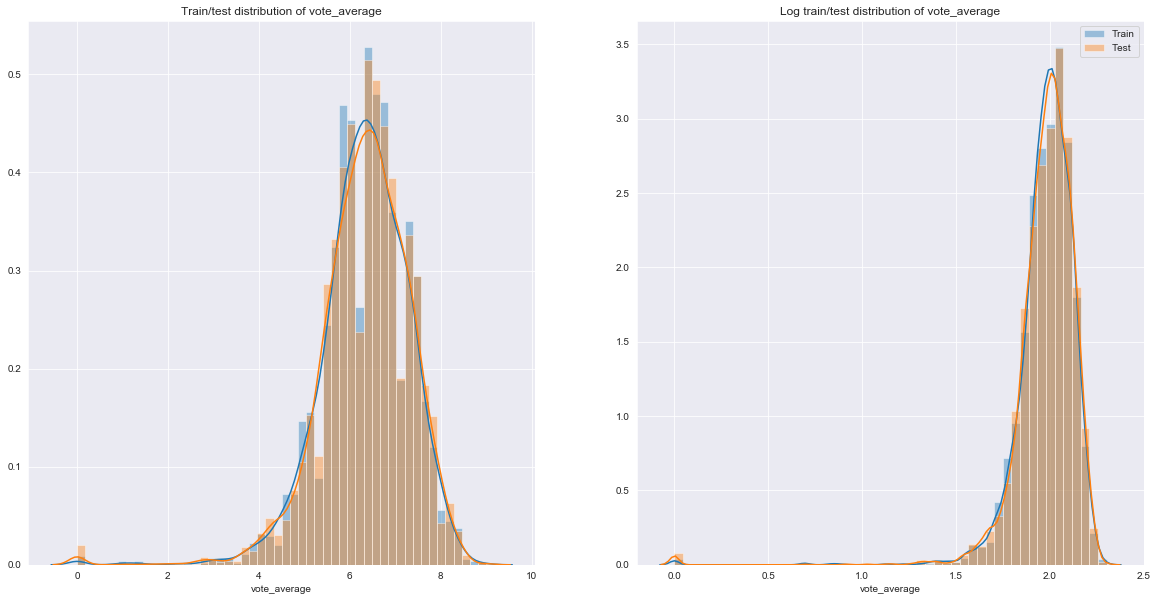

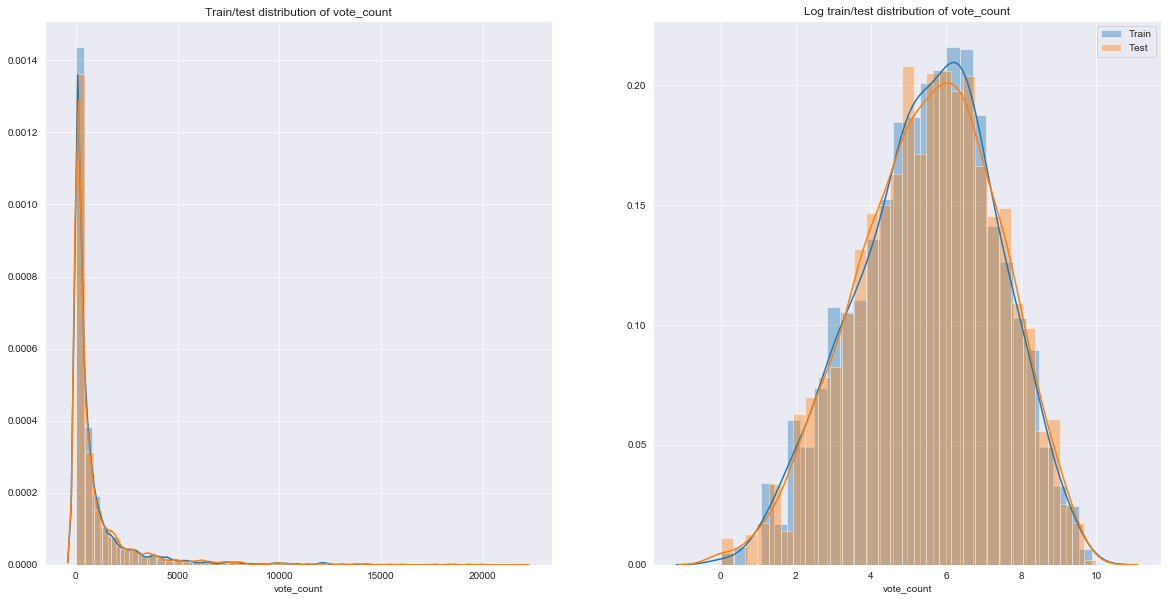

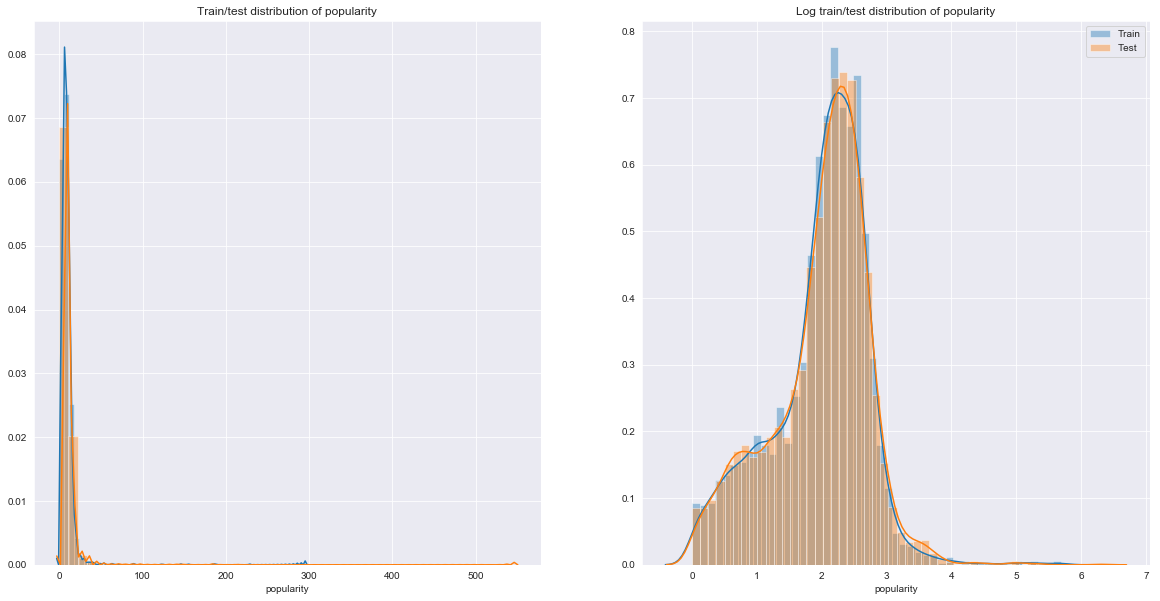

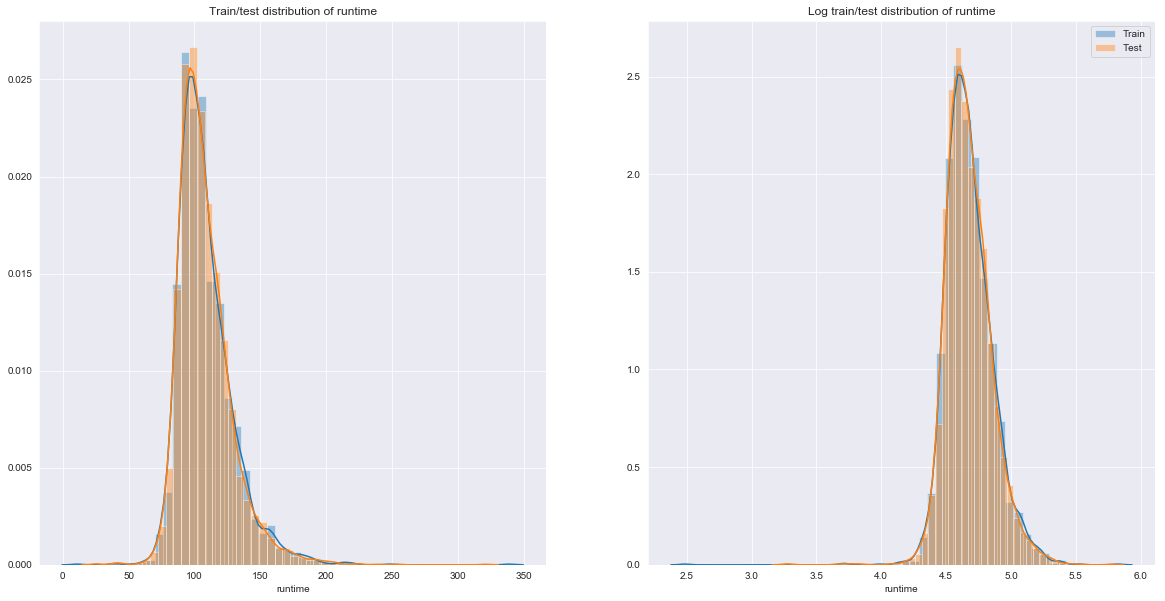

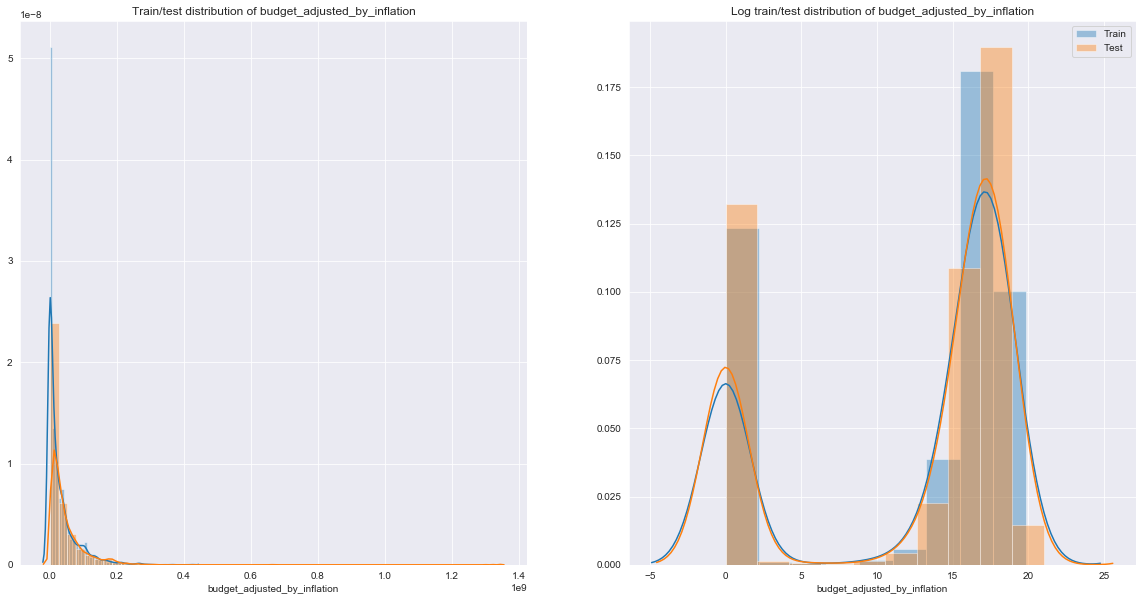

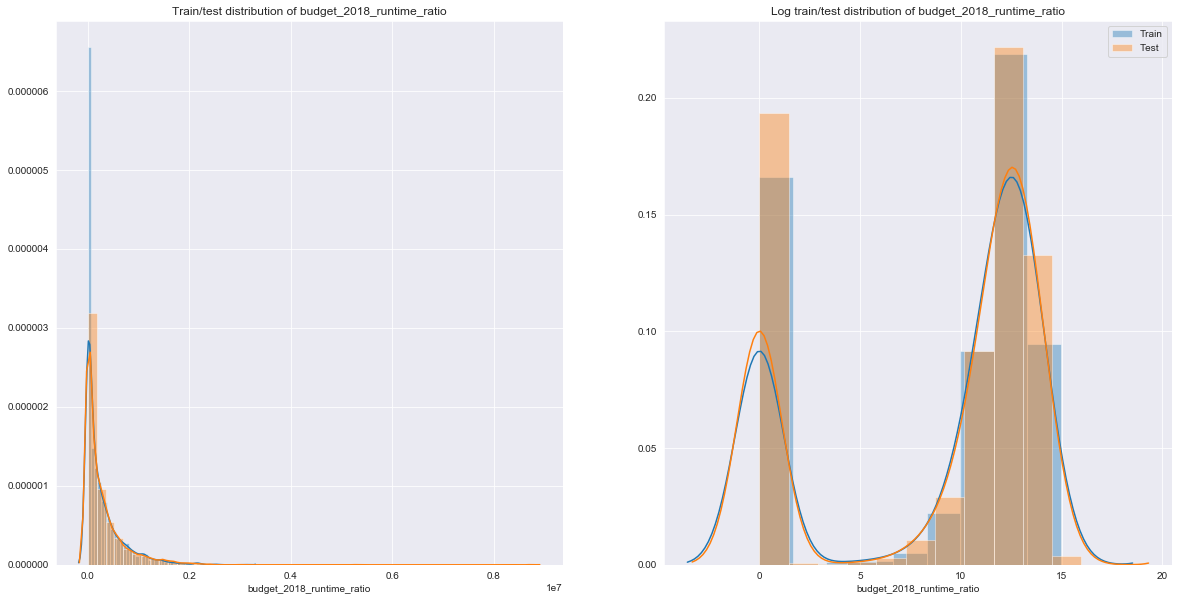

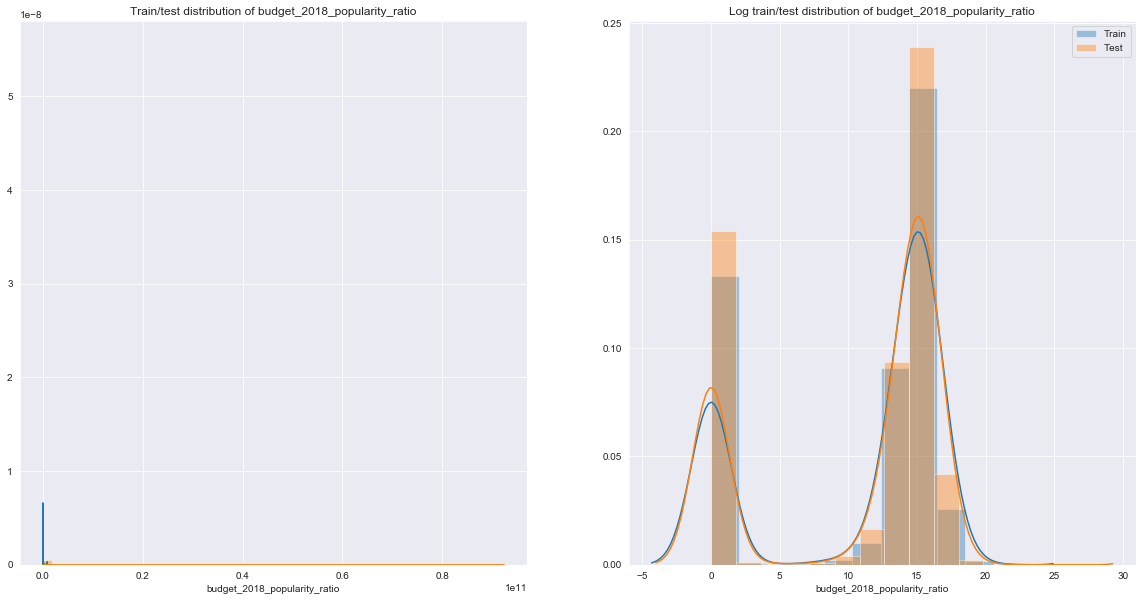

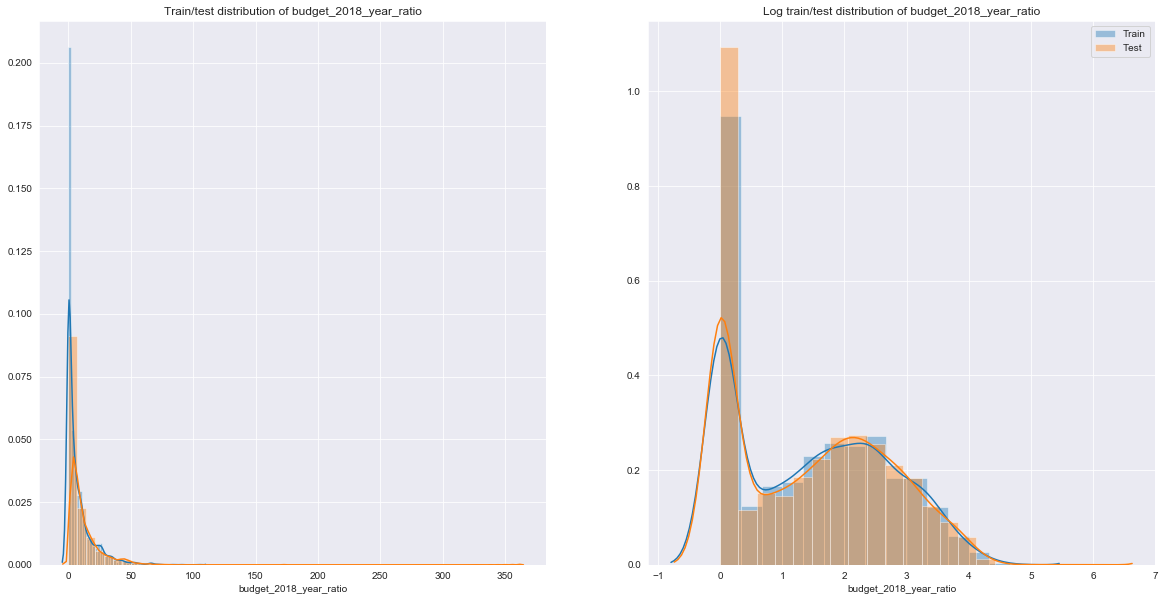

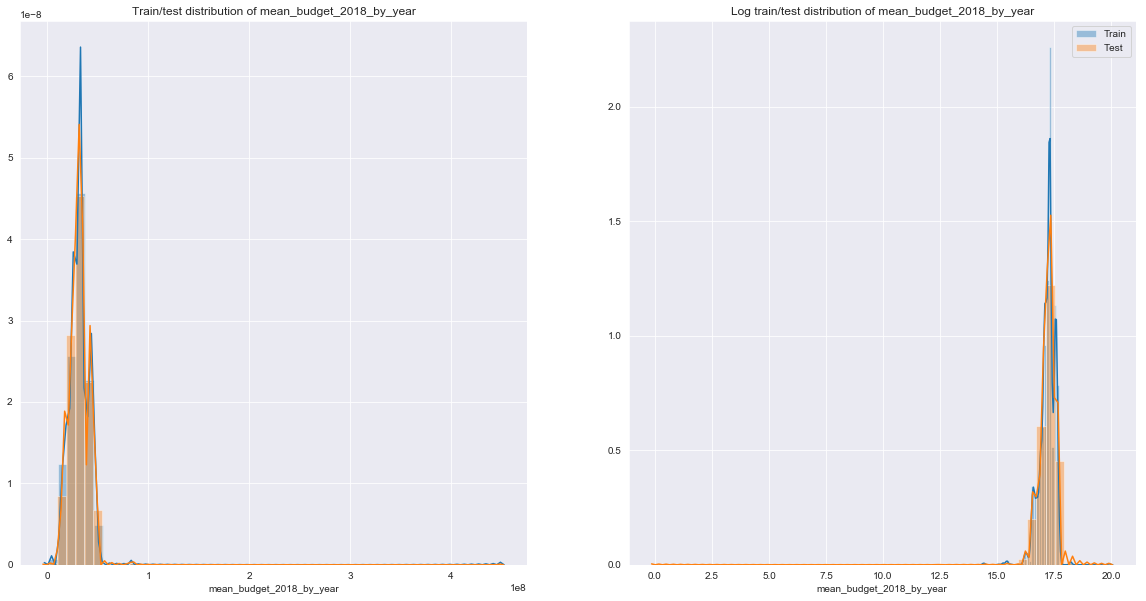

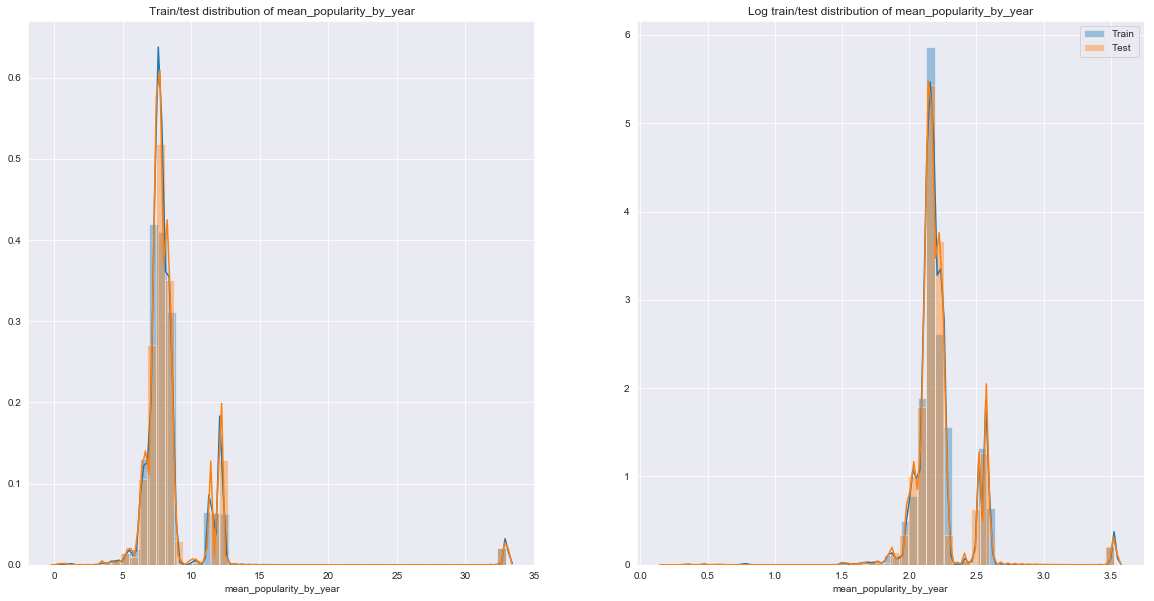

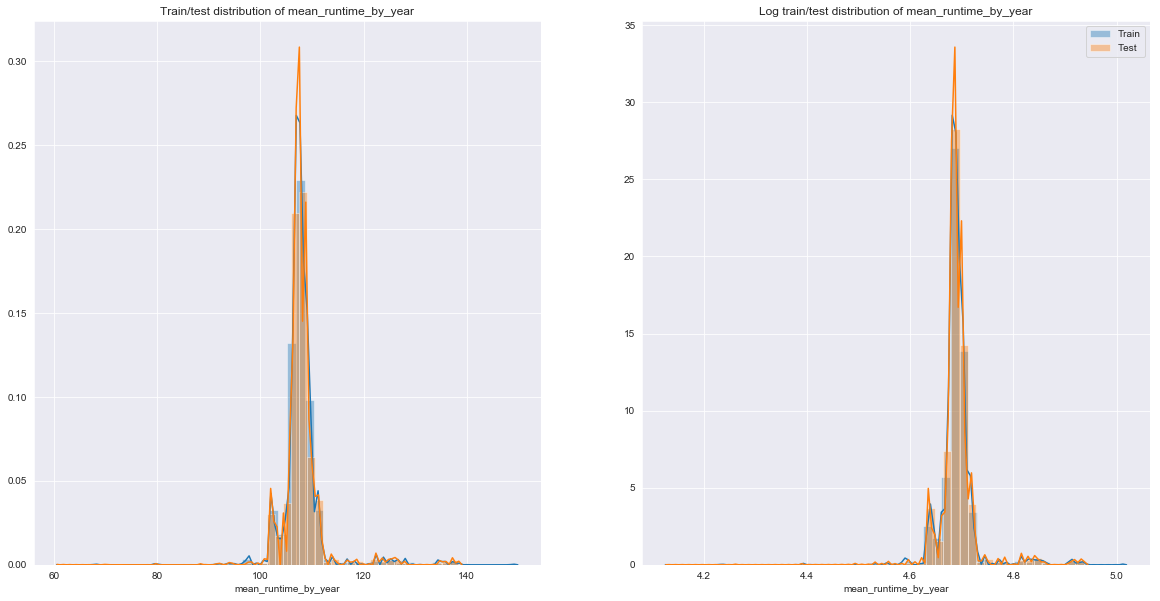

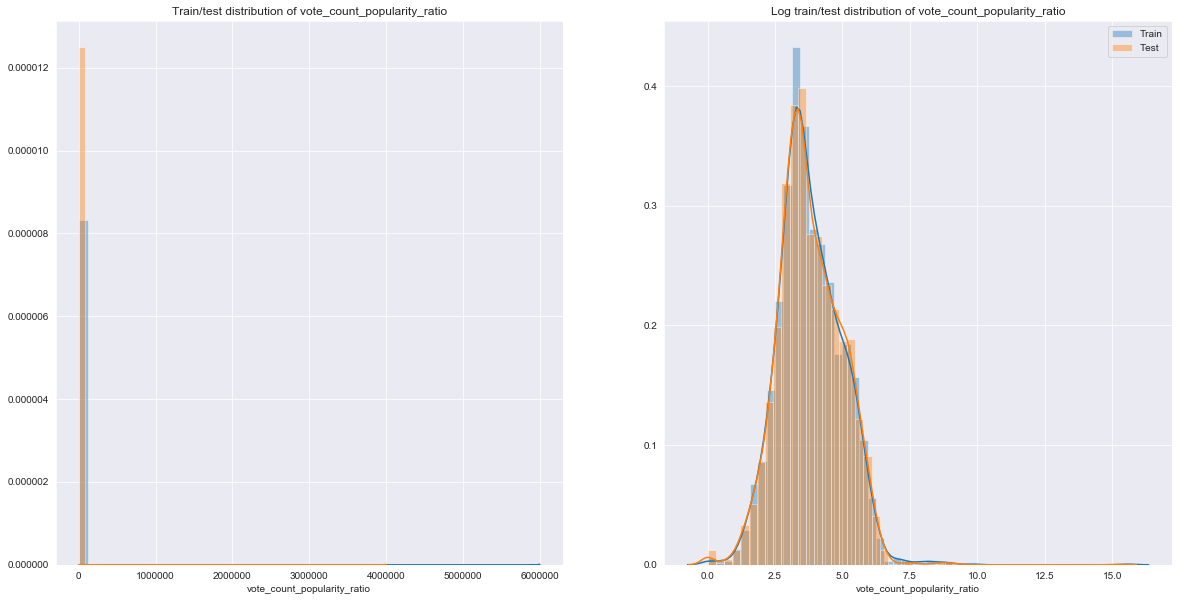

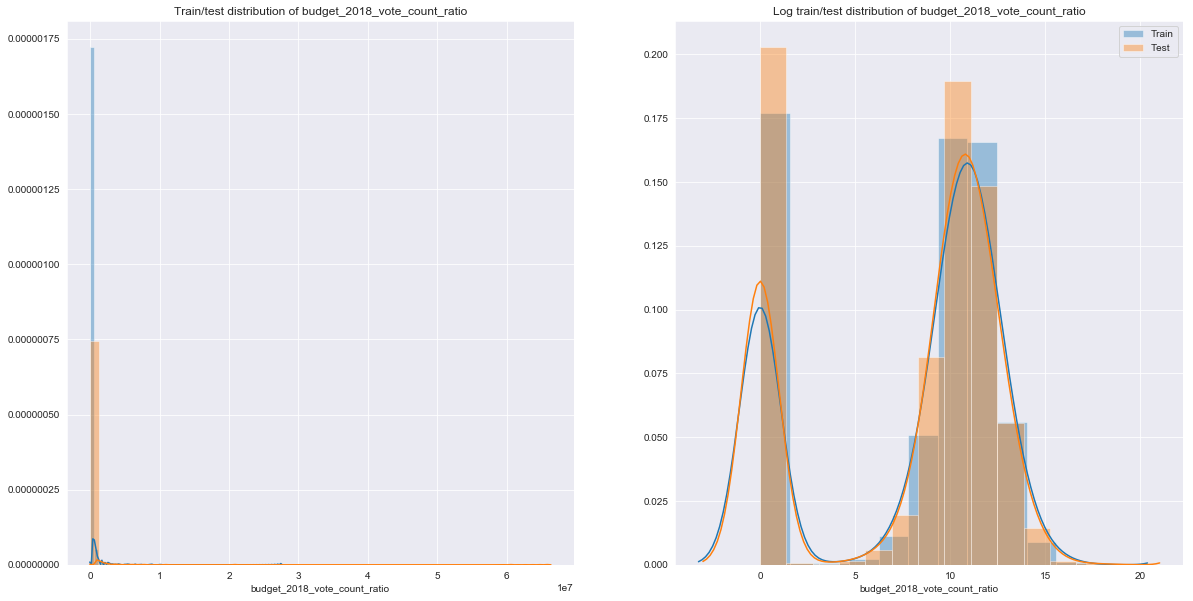

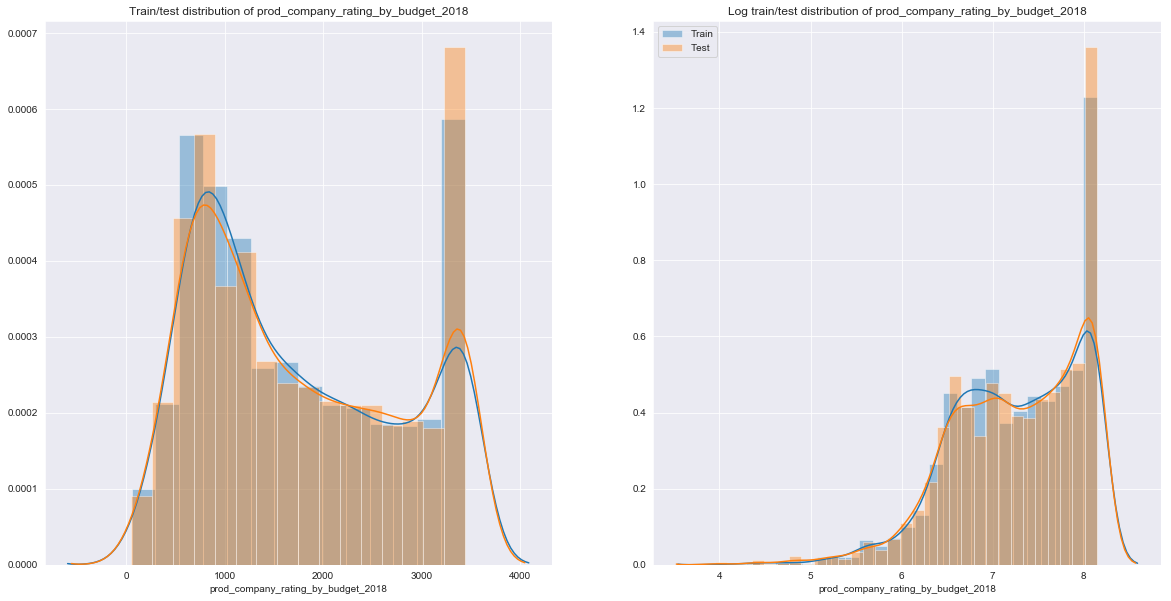

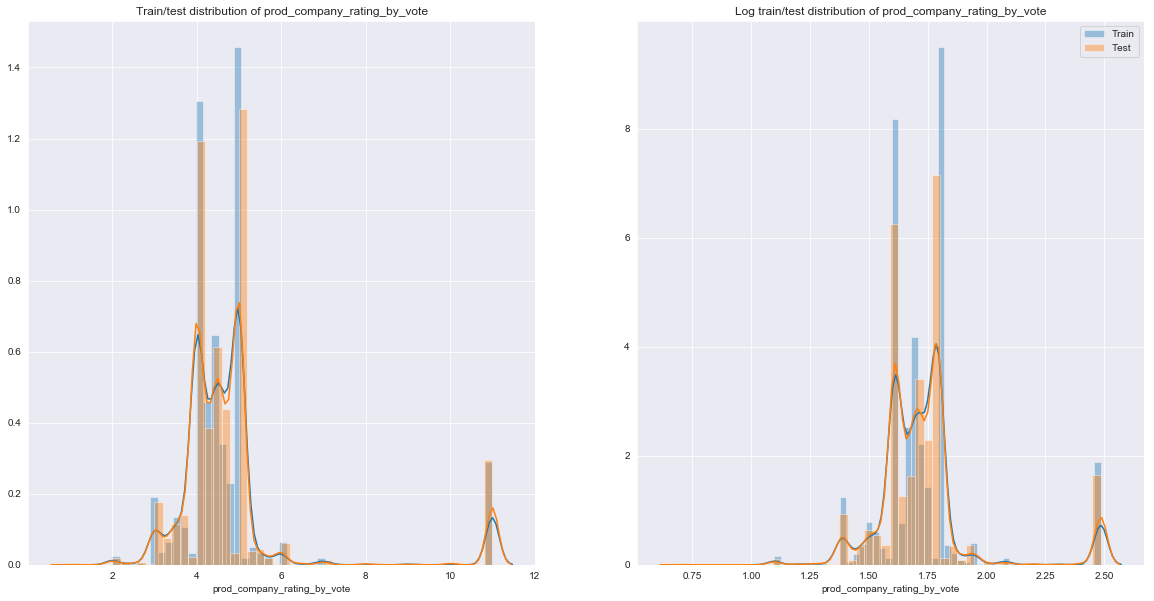

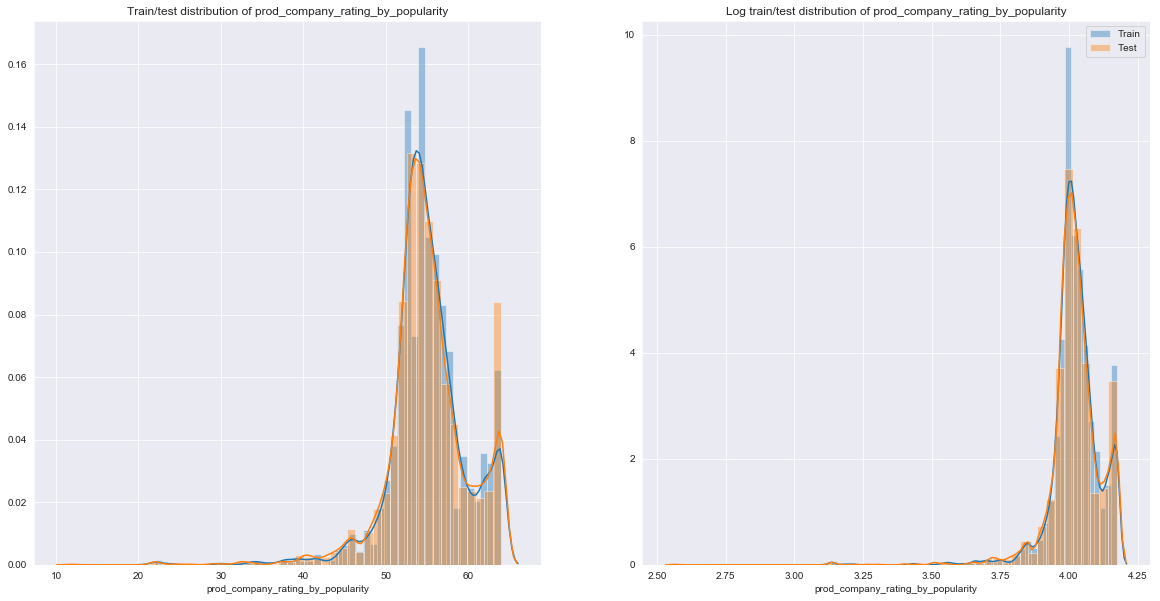

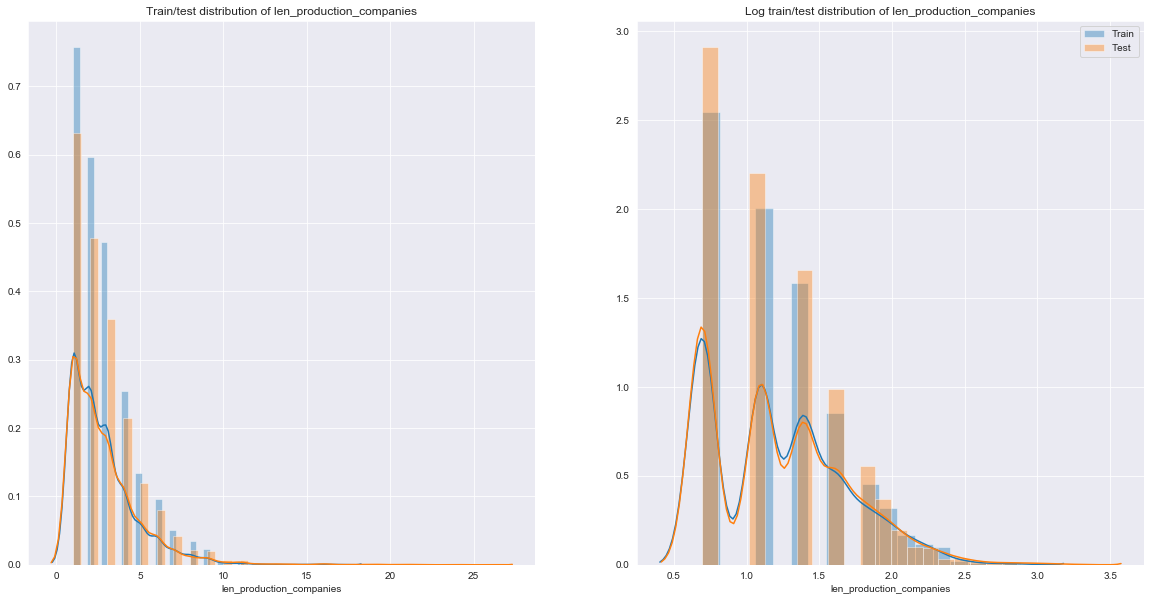

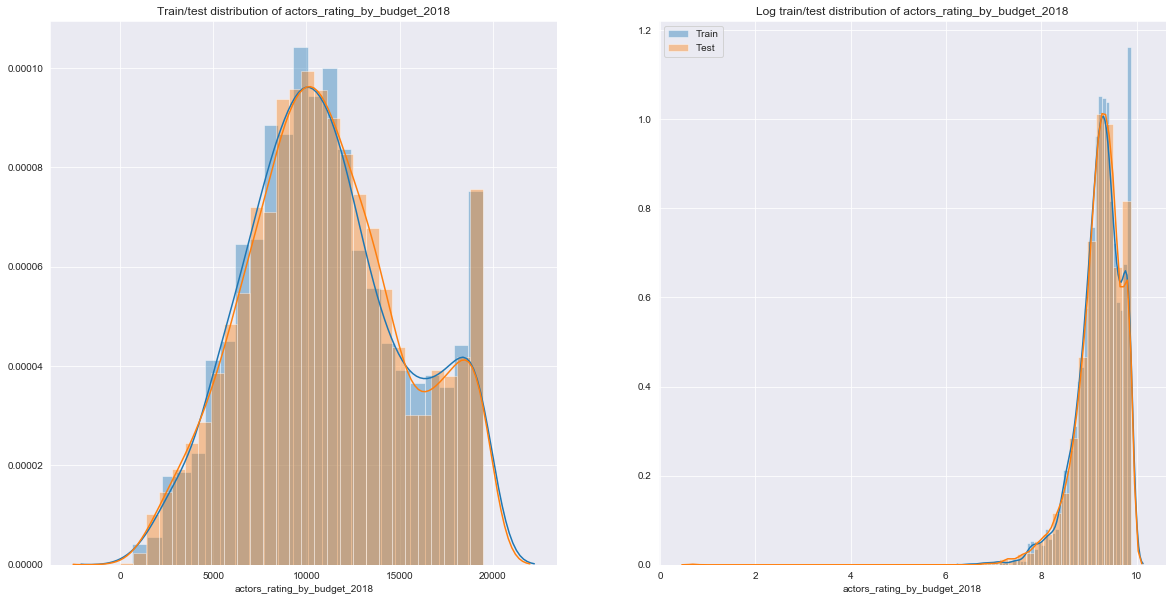

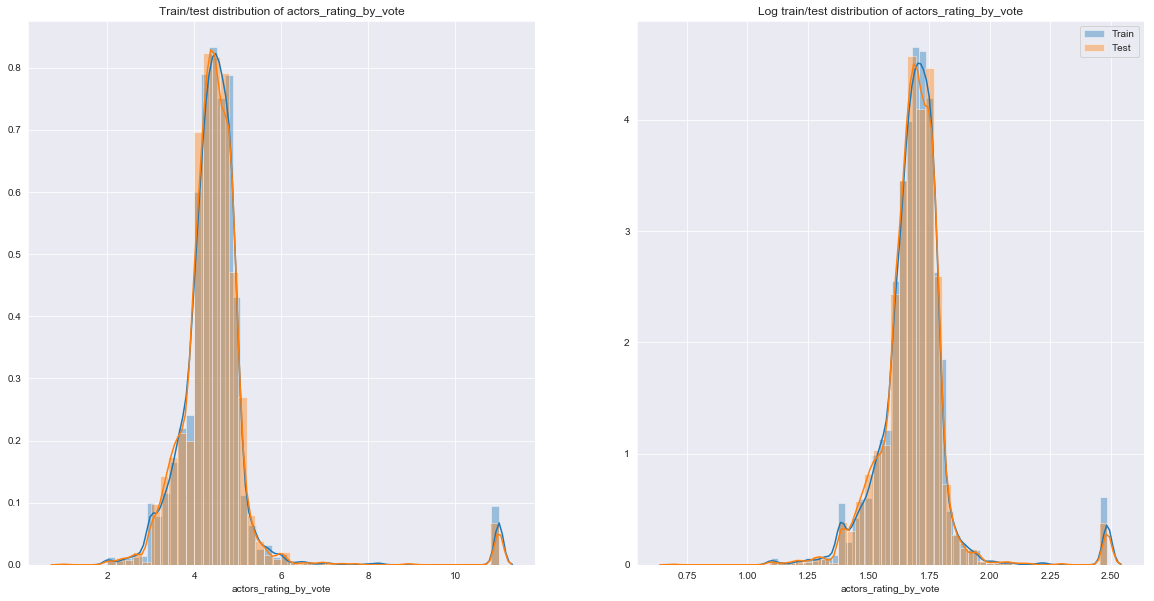

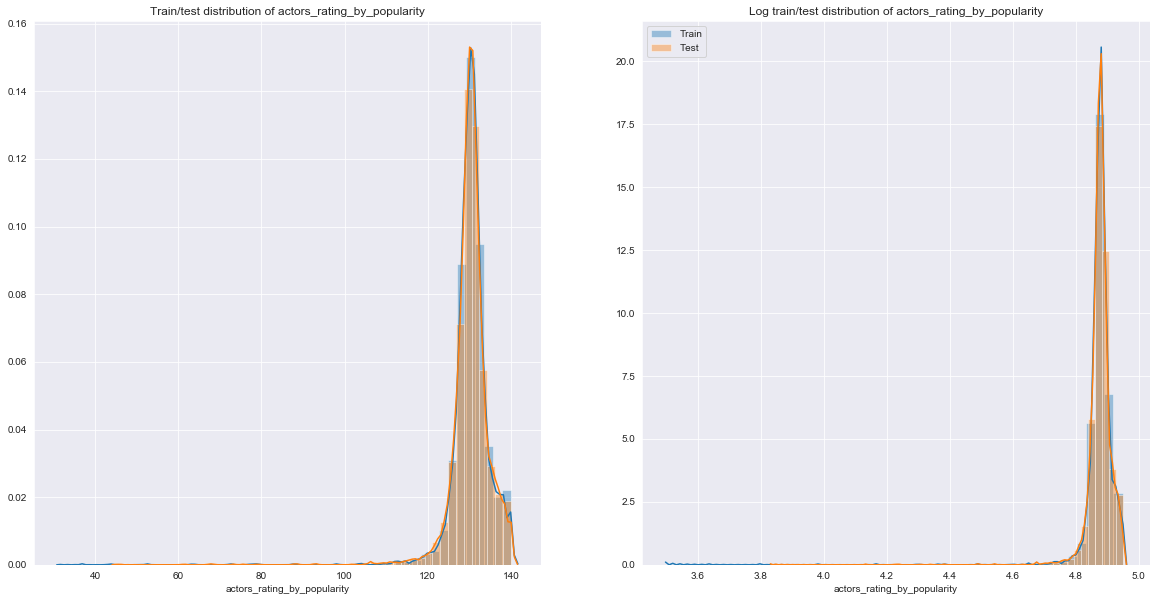

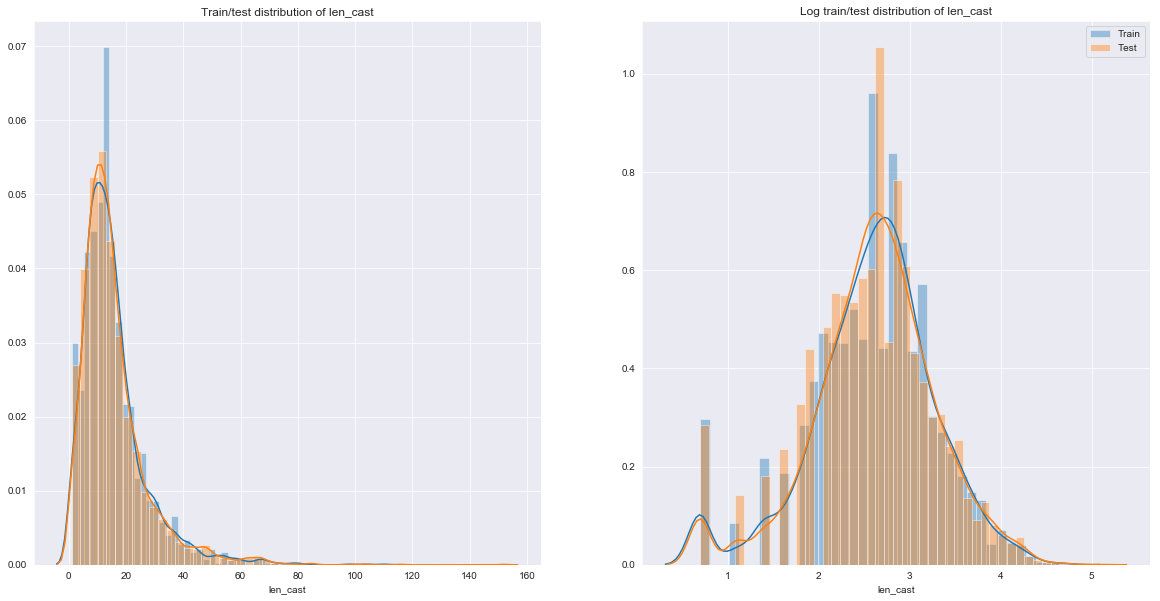

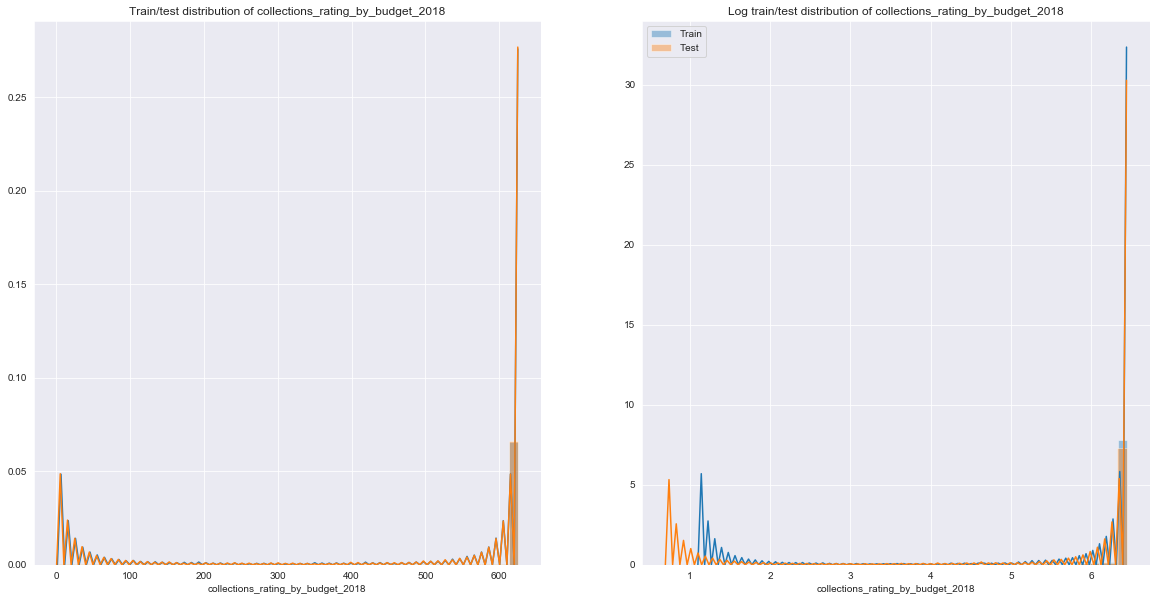

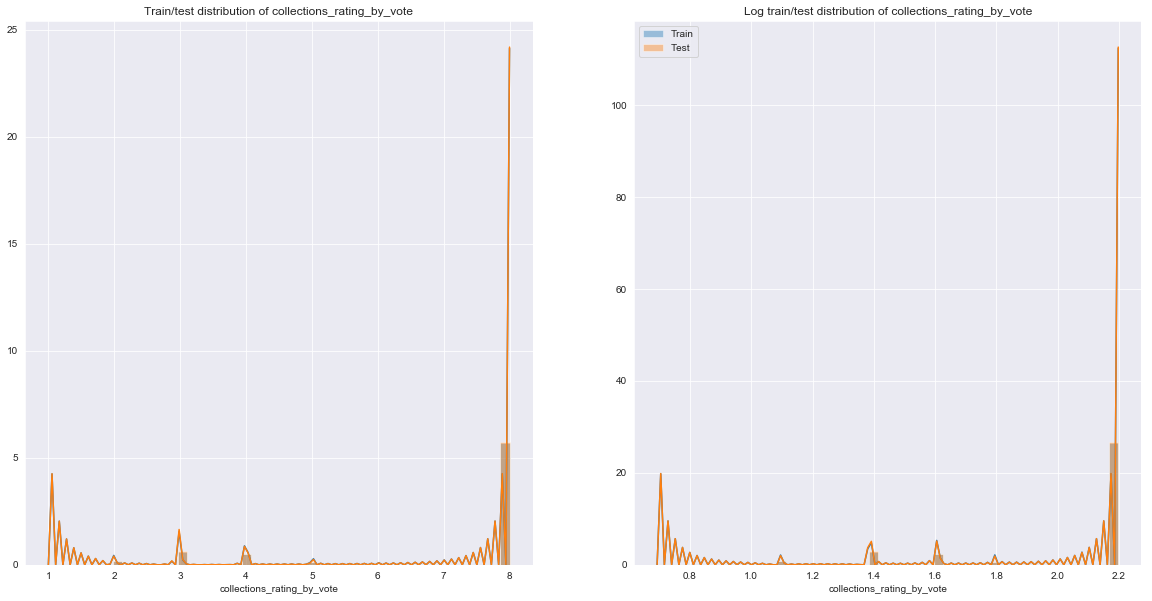

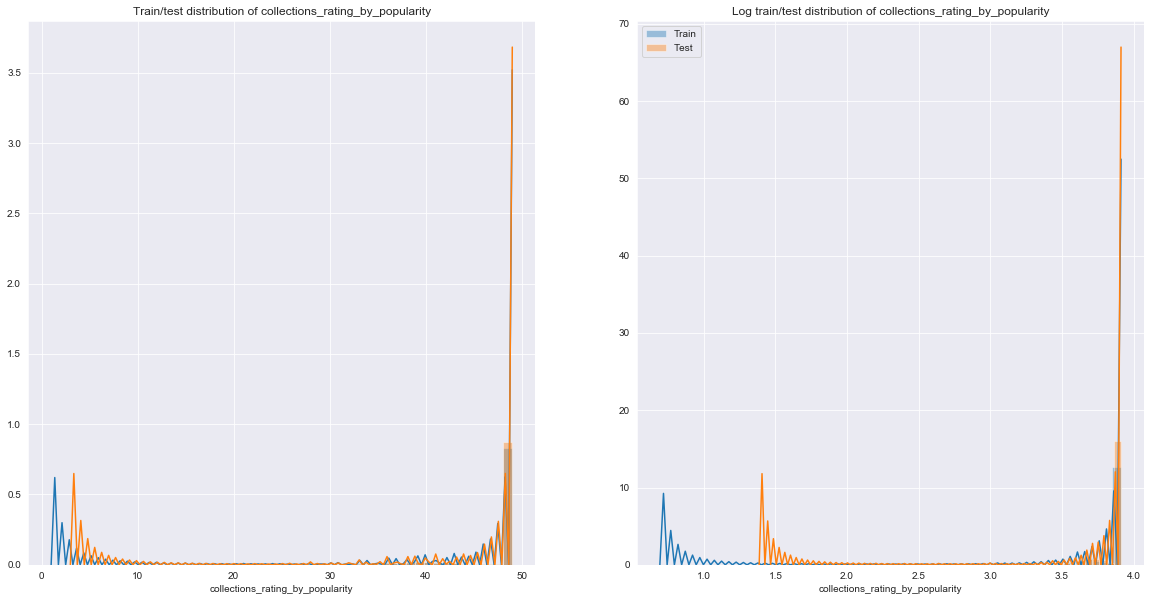

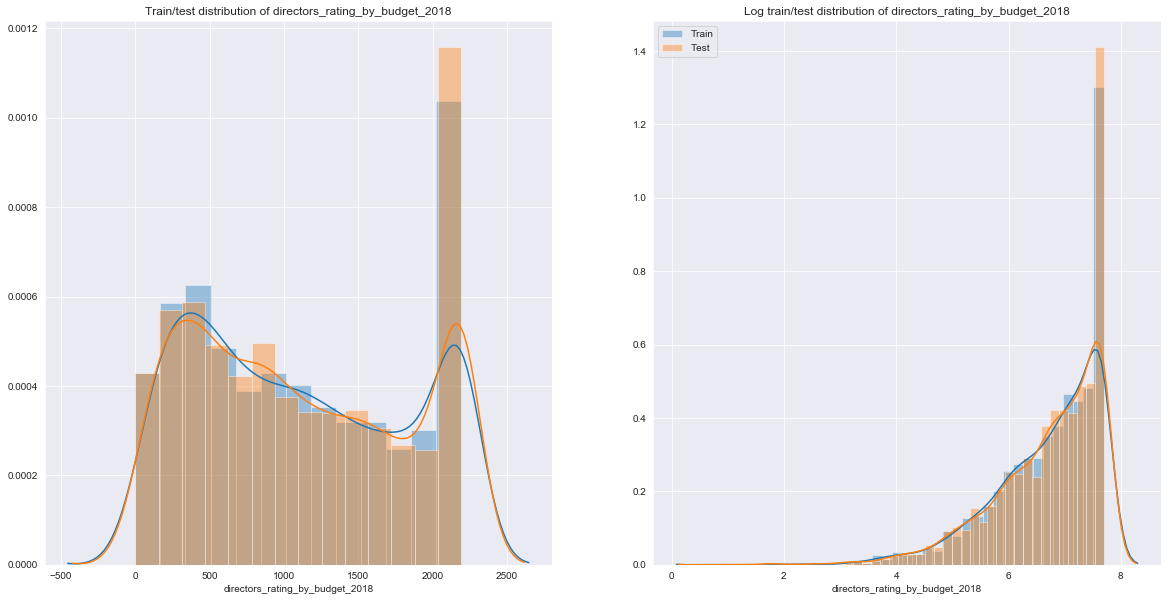

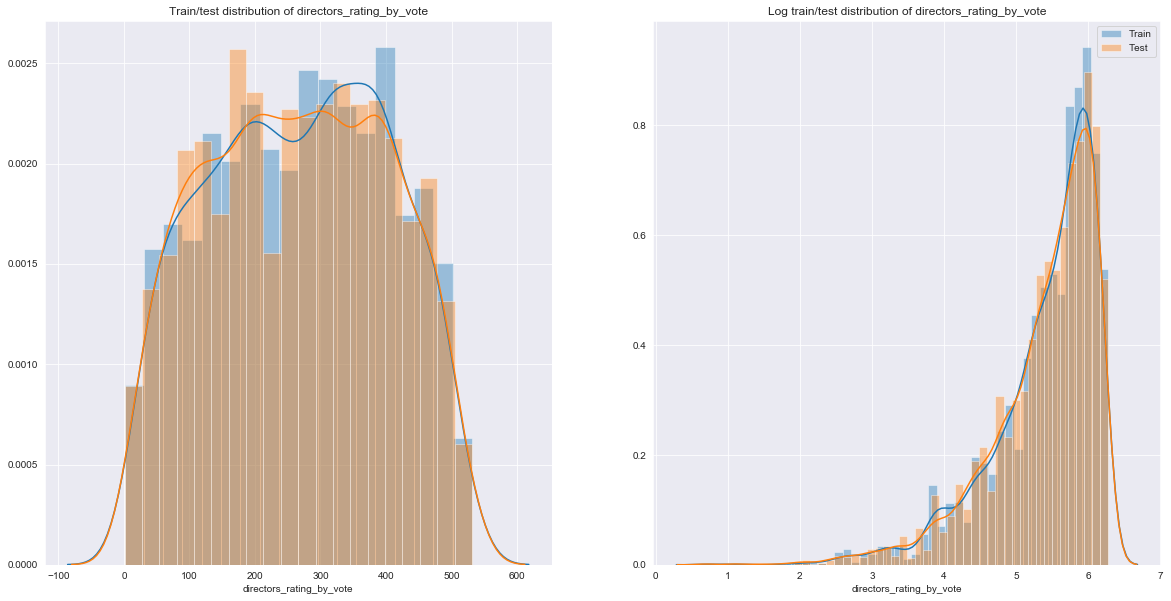

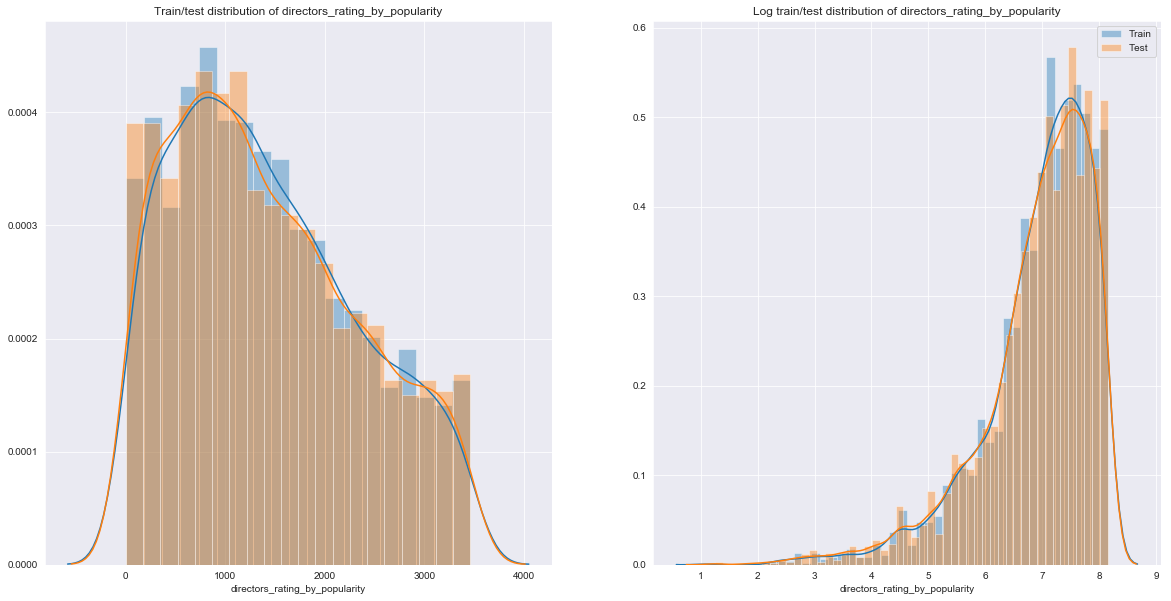

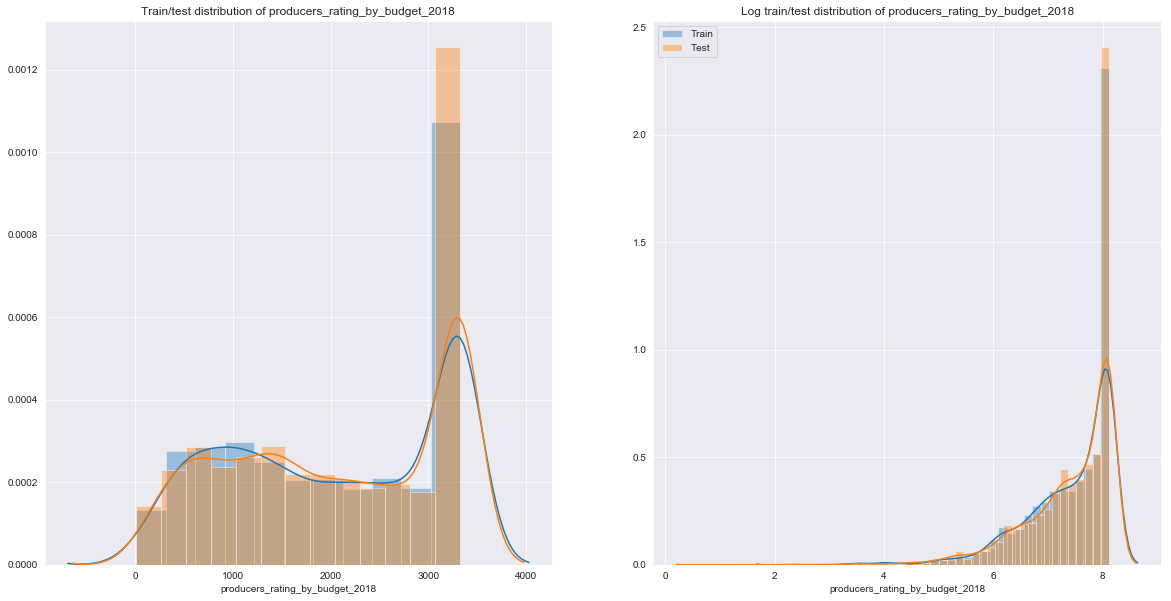

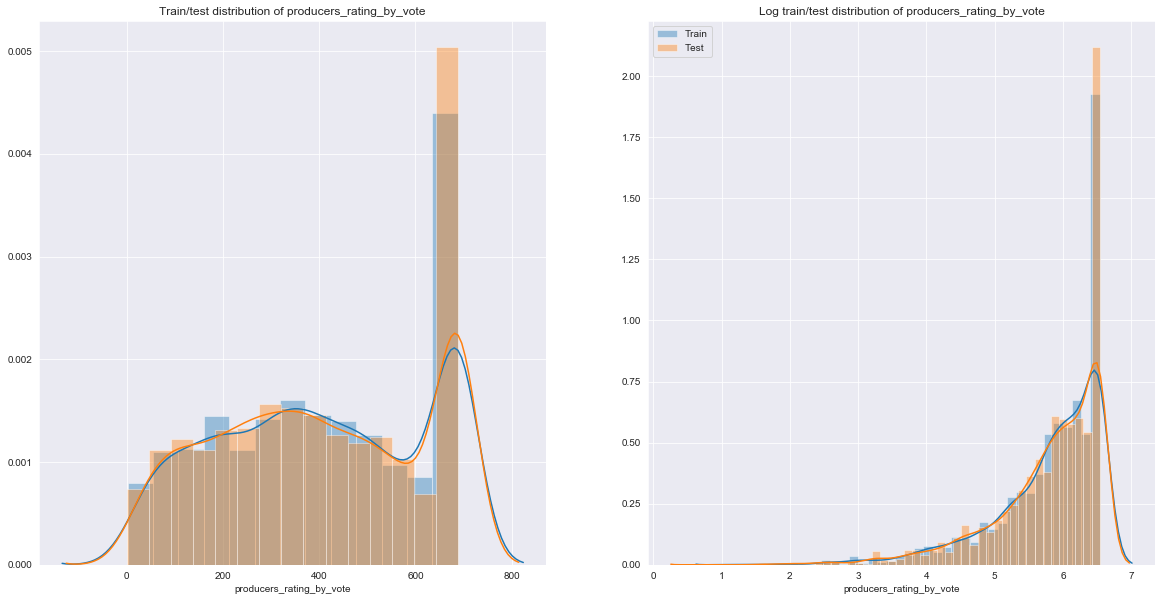

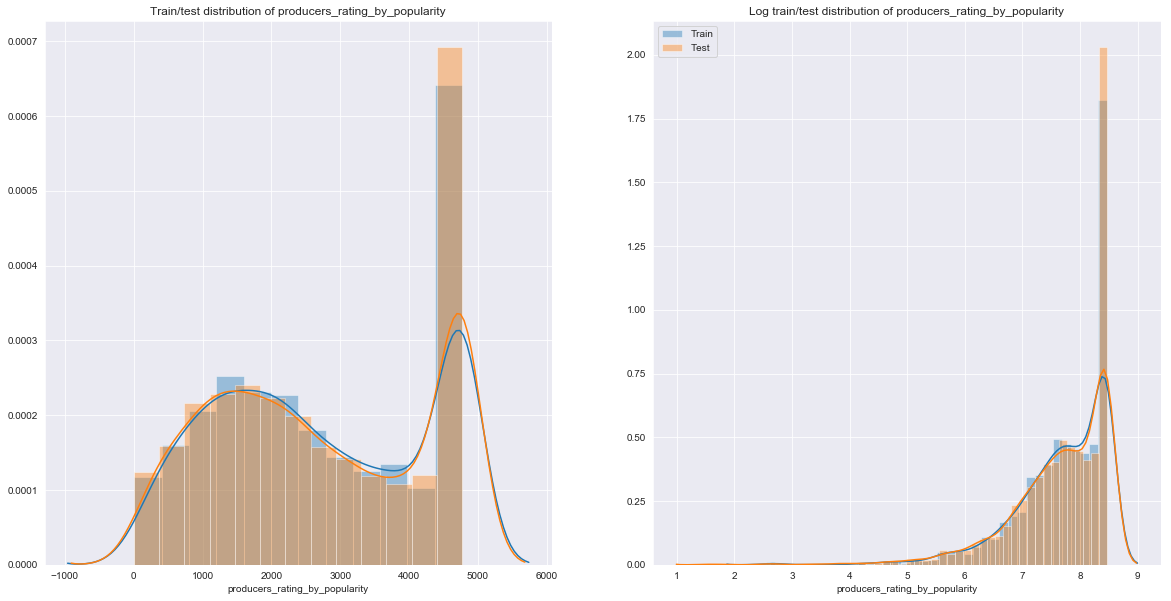

In [71]:
for feature_name in features_for_plot:
    _, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
    sns.distplot(train_construct_data[feature_name], label='Train', ax=ax[0])
    sns.distplot(test_construct_data[feature_name], label='Test', ax=ax[0])
    ax[0].set_title('Train/test distribution of ' + feature_name)
    plt.legend(labels=['Train', 'Test'])
    sns.distplot(np.log1p(train_construct_data[feature_name]), label='Train', ax=ax[1])
    sns.distplot(np.log1p(test_construct_data[feature_name]), label='Test', ax=ax[1])
    ax[1].set_title('Log train/test distribution of ' + feature_name)
    plt.legend(labels=['Train', 'Test'])
    plt.show()

Apply log-transformation for some features.

In [72]:
features_for_log = ['vote_count', 'popularity', 'runtime', 'budget_adjusted_by_inflation', 
                    'budget_2018_runtime_ratio', 'budget_2018_popularity_ratio', 'budget_2018_year_ratio', 
                    'vote_count_popularity_ratio', 'budget_2018_vote_count_ratio', 'len_cast']
for feature_name in features_for_log:
    construct_data['log_' + feature_name] = np.log1p(construct_data[feature_name])
construct_data.drop(features_for_log, axis=1, inplace=True)

In [73]:
construct_data.head()

,release_day,release_month,release_year,homepage_bool,belongs_to_collections_bool,len_prod_countries,len_spoken_languages,vote_average,genre_Romance,genre_Family,...,log_vote_count,log_popularity,log_runtime,log_budget_adjusted_by_inflation,log_budget_2018_runtime_ratio,log_budget_2018_popularity_ratio,log_budget_2018_year_ratio,log_vote_count_popularity_ratio,log_budget_2018_vote_count_ratio,log_len_cast
0,20,2,2015,0,1,1,1,5.1,0,0,...,6.212606,2.024905,4.543295,16.512315,11.979722,14.628981,1.537526,4.340383,10.301749,3.135494
1,6,8,2004,0,1,1,1,6.4,1,1,...,7.416980,2.224504,4.736198,17.789051,13.061666,15.678972,2.656062,5.311247,10.372704,2.995732
2,10,10,2014,1,0,1,1,8.4,0,0,...,8.956609,4.178992,4.663439,15.068367,10.414436,10.904825,0.622165,4.801174,6.114101,3.044522
3,9,3,2012,1,0,1,2,7.5,0,0,...,4.812184,1.429099,4.812184,14.087399,9.283471,12.932114,0.280814,3.674425,9.283471,1.945910
4,5,2,2009,0,0,1,1,5.7,0,0,...,2.302585,0.764570,4.779123,0.000000,0.000000,0.000000,0.000000,2.179201,0.000000,1.609438


**Modeling**

In [74]:
train_construct_data = construct_data.loc[:2999, :]
target = np.log(target_adjusted_by_inflation)
test_construct_data = construct_data.loc[3000:, :]

In [75]:
X_train, X_test, y_train, y_test = train_test_split(train_construct_data, 
                                                    target, 
                                                    test_size=0.2)

Primitive model accuracy:

In [76]:
xgboost_est = XGBRegressor(booster='gbtree', random_state=42)
xgboost_score = cross_val_score(estimator=xgboost_est, 
                                X=X_train, 
                                y=y_train, 
                                scoring='neg_mean_squared_error', 
                                cv=5)
print('CV-results: {}'.format(xgboost_score))
print('Mean: {}'.format(np.mean(xgboost_score)))

CV-results: [-5.67968874 -4.04418344 -3.99549616 -3.8647407  -4.46144172]
Mean: -4.409110151899588


Standart scaling:

In [77]:
X_train, X_test, y_train, y_test = train_test_split(train_construct_data, 
                                                    target, 
                                                    test_size=0.2)
std_scaler = StandardScaler()
X_train_scaled = std_scaler.fit_transform(X_train);
X_test_scaled = std_scaler.transform(X_test)

Truncation of feature set. Many of them  add noise to the data.

10
20
30
40
50
60
70
80
90
100


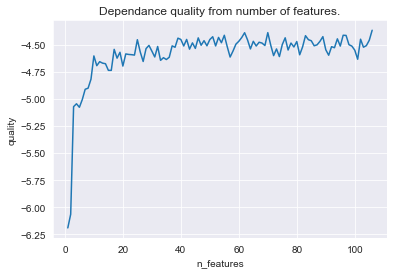

In [78]:
X_train_scaled_pd = pd.DataFrame(X_train_scaled, 
                                 columns=train_construct_data.columns)
xgboost = XGBRegressor(
     learning_rate = 0.1, 
     n_estimators = 70, 
     max_depth = 7, 
     min_child_weight = 14, 
     subsample = 0.5, 
     colsample_bytree = 0.5,
     gamma = 0.001, 
     reg_alpha = 0.0001,
     reg_lambda = 3,
     n_jobs = -1,
     scale_pos_weight = 1,
     random_state=42)
best_feature_subset(xgboost, X_train_scaled_pd, y_train, 'neg_mean_squared_error', verbose=10)

It is looked like about 40 features include main information about data set. 

In [91]:
truncated_features = feature_importances(estimator=xgboost, 
                                         X=train_construct_data, 
                                         y=target, 
                                         n_features_return=40, 
                                         plot_flag=False)
X_train, X_test, y_train, y_test = train_test_split(train_construct_data.loc[:, truncated_features], 
                                                    target, 
                                                    test_size=0.2)
std_scaler = StandardScaler()
X_train_scaled = std_scaler.fit_transform(X_train);
X_test_scaled = std_scaler.transform(X_test)

Primitive model accuracy:

In [92]:
xgboost_est = XGBRegressor(booster='gbtree', random_state=42)
xgboost_score = cross_val_score(estimator=xgboost_est, 
                                X=X_train_scaled, 
                                y=y_train, 
                                scoring='neg_mean_squared_error', 
                                cv=10)
print('CV-results: {}'.format(xgboost_score))
print('Mean: {}'.format(np.mean(xgboost_score)))

CV-results: [-2.54682247 -3.52557423 -4.91997937 -2.34635255 -2.96331719 -3.26311334
 -4.9487126  -7.07446347 -5.36234672 -5.90160826]
Mean: -4.285229018734722


Train primitive Ridge, Lasso, Elastic, Bayesian, RandForest, GradBoost, LassoLars, XGBoost models.

In [93]:
ridge_reg = Ridge()
lasso_reg = Lasso()
elastic_reg = ElasticNet()
bayesian_reg = BayesianRidge()
rand_forest_reg = RandomForestRegressor()
grad_boost_reg = GradientBoostingRegressor()
xgboost_reg = XGBRegressor()
lasso_lars_reg = LassoLarsIC()

reg_list = [ridge_reg, lasso_reg, elastic_reg, bayesian_reg, rand_forest_reg,
              grad_boost_reg, lasso_lars_reg, xgboost_reg]
reg_index = ['Ridge', 'Lasso', 'Elastic', 'Bayesian', 
             'RandForest', 'GradBoost', 'LassoLars', 'XGBoost']

regressors = {pair[0] : pair[1] for pair in zip(reg_index, reg_list)}

quality = pd.DataFrame(index=regressors.keys(), columns=['Quality'])
for name, reg in regressors.items():
    new_reg = clone(reg)
    new_reg.fit(X_train_scaled, y_train)
    temp_qual = mean_squared_error(new_reg.predict(X_test_scaled), y_test)
    quality.loc[name, 'Quality'] = np.sqrt(temp_qual)

Quality (RMSLE):

In [94]:
quality

,Quality
Ridge,2.19453
Lasso,2.49983
Elastic,2.37192
Bayesian,2.17562
RandForest,2.16748
GradBoost,2.03669
LassoLars,2.18557
XGBoost,2.03938


Get more precise estimation of quality single model.

In [95]:
def quality_measurment_of_model(model_, data, target, metric, n_iterations=50):
    train_error = []
    test_error = []
    for iteration in range(n_iterations):
        X_train, X_test, y_train, y_test = train_test_split(data, 
                                                            target, 
                                                            test_size=0.2, 
                                                            shuffle=True)
        model = clone(model_)
        model.fit(X_train,  y_train)
        train_error.append(metric(y_train, model.predict(X_train)))
        test_error.append(metric(y_test, model.predict(X_test)))
    return {'Train': np.mean(train_error), 'Test': np.mean(test_error)}

In [96]:
qual = quality_measurment_of_model(GradientBoostingRegressor(), 
                                   X_train_scaled, 
                                   y_train, 
                                   mean_squared_error, 
                                   n_iterations=100)

In [97]:
qual

{'Train': 2.2140809585032653, 'Test': 4.354149448159886}

Get more precise estimation of quality many models.

In [98]:
def quality_measurment_of_models(models_dic, data, target, metric, n_iterations=50):
    results = {}
    for model_name in models_dic.keys():
        print(model_name)
        train_error = []
        test_error = []
        for iteration in range(n_iterations):
            model = clone(models_dic[model_name])
            X_train, X_test, y_train, y_test = train_test_split(data, 
                                                                target, 
                                                                test_size=0.2, 
                                                                shuffle=True)
            model.fit(X_train,  y_train)
            train_error.append(metric(y_train, model.predict(X_train)))
            test_error.append(metric(y_test, model.predict(X_test)))
        results[model_name] = [np.mean(train_error), np.mean(test_error)]
    return pd.DataFrame(results, index=['Train', 'Test'])

In [99]:
regressors_qual = quality_measurment_of_models(regressors, 
                                               X_train_scaled, 
                                               y_train, 
                                               mean_squared_error, 
                                               n_iterations=100)

Ridge
Lasso
Elastic
Bayesian
RandForest
GradBoost
LassoLars
XGBoost


In [100]:
regressors_qual

,Ridge,Lasso,Elastic,Bayesian,RandForest,GradBoost,LassoLars,XGBoost
Train,4.106305,6.226726,5.507715,4.287985,0.893089,2.210554,4.052881,2.344558
Test,4.264730,6.167157,5.370334,4.413003,5.043071,4.435196,55.282895,4.335718


Tuning single model's parameters was like this:

In [101]:
xgboost = XGBRegressor(
     learning_rate = 0.1, 
     n_estimators = 60, 
     max_depth = 5, 
     min_child_weight = 1, 
     gamma = 0, 
     subsample = 0.8, 
     colsample_bytree = 0.8,
     n_jobs = -1,
     scale_pos_weight = 1,
     random_state=42)

grid_params = {
     'max_depth': np.arange(5, 15),
     'min_child_weight': np.arange(5, 15)
}

grid_search = GridSearchCV(estimator=xgboost, 
                           param_grid=grid_params, 
                           cv=5, 
                           scoring='neg_mean_squared_error', 
                           return_train_score=True)
grid_search.fit(X=X_train_scaled, y=y_train)
print('Best_params: ', grid_search.best_params_)
print('Best score: ', grid_search.best_score_)
print('Mean_test_score for all parameters: ', grid_search.cv_results_['mean_test_score'])
xgboost = grid_search.best_estimator_
xgboost.fit(X_train_scaled, y_train)
print('Accuracy_test of the best (RMSLE): ', np.sqrt(mean_squared_error(xgboost.predict(X_test_scaled), y_test)))
print('Accuracy_train of the best (RMSLE): ', np.sqrt(mean_squared_error(xgboost.predict(X_train_scaled), y_train)))

Best_params:  {'max_depth': 7, 'min_child_weight': 10}
Best score:  -4.277626429418966
Mean_test_score for all parameters:  [-4.38087981 -4.38405089 -4.31563753 -4.32136643 -4.36150149 -4.3586385
 -4.38299066 -4.3234365  -4.31833825 -4.30030172 -4.4455146  -4.35754211
 -4.35568726 -4.40918752 -4.45068916 -4.37507452 -4.45042674 -4.32695299
 -4.3445604  -4.39424779 -4.44907642 -4.45436085 -4.41778399 -4.3771944
 -4.38940599 -4.27762643 -4.34702043 -4.38175091 -4.40673939 -4.36328739
 -4.39724492 -4.38185153 -4.48356614 -4.33485762 -4.44351866 -4.34418325
 -4.30107334 -4.38790652 -4.32241063 -4.35620123 -4.46098584 -4.45404606
 -4.37858066 -4.43943916 -4.46114682 -4.41060767 -4.36733484 -4.39552511
 -4.38006936 -4.34336724 -4.4638478  -4.4220377  -4.35553599 -4.38689052
 -4.38955147 -4.39913558 -4.4107459  -4.32545296 -4.37314932 -4.31480735
 -4.38414161 -4.30698151 -4.38640361 -4.44355295 -4.38263039 -4.46693055
 -4.44377618 -4.30656686 -4.38769147 -4.33286987 -4.44823931 -4.53406978
 -

Finally tuned single model looks like:

In [102]:
xgboost = XGBRegressor(
     learning_rate = 0.01, 
     n_estimators = 1000, 
     max_depth = 5, 
     min_child_weight = 12, 
     gamma = 0, 
     subsample = 0.8, 
     colsample_bytree = 0.8,
     reg_alpha = 1e-5,
     reg_lambda = 1,
     n_jobs = -1,
     scale_pos_weight = 1,
     random_state=42)
xgboost_score = cross_val_score(estimator=xgboost, 
                                X=X_train_scaled, 
                                y=y_train, 
                                scoring='neg_mean_squared_error', 
                                cv=5, 
                                n_jobs=-1)
print('CV-results: {}'.format(xgboost_score))
print('Mean: {}'.format(np.mean(xgboost_score)))
xgboost.fit(X_train_scaled, y_train)
print('Accuracy_test (RMSLE): ', np.sqrt(mean_squared_error(xgboost.predict(X_test_scaled), y_test)))
print('Accuracy_train (RMSLE): ', np.sqrt(mean_squared_error(xgboost.predict(X_train_scaled), y_train)))

CV-results: [-2.85466811 -3.57178041 -3.15710948 -6.01276474 -5.5320145 ]
Mean: -4.225667447725661
Accuracy_test:  2.0226035295346025
Accuracy_train:  1.1734131061957327


After fitting another models I got some variants of answers. The submission takes annoying top 32% in leaderboard. I was only 435 of 1400 with RMSE-score 1.96070.